In [1]:
# !pip3 list

In [2]:
import os
import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from pandasql import sqldf
import random
from datetime import date
import datetime
import scipy
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from cleantext import clean
from unidecode import unidecode
import duckdb

/Users/sreevaatsav/.pyenv/versions/project_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# https://www.kaggle.com/code/colearninglounge/nlp-data-preprocessing-and-cleaning

def remove_hashtags(data):
    clean_data = re.sub(r"#[A-Za-z0-9_]+", "", data)
    clean_data = re.sub(r"\$[A-Za-z0-9_]+", "", clean_data)
    return clean_data

def remove_hashsymbol(data):
    clean_data = re.sub(r"#", "", data)
    return clean_data

def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

def remove_html(data):
    data = re.sub(r"https?://[^\s]+", "", data)
    
    return data

def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

def remove_html(data):
    data = re.sub(r"https?://[^\s]+", "", data)
    
    return data

def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

def remove_stopwords(df, column):
    stop_words = set(stopwords.words("english"))
    stop_words.add("see")
    
    def remove_stopwords_from_text(text):
        word_tokens = word_tokenize(text)
        filtered_tokens = [token for token in word_tokens if not token.lower() in stop_words]
        return " ".join(filtered_tokens)
    
    df[column] = df[column].apply(remove_stopwords_from_text)
    return df

def clean_text_complete(text):
    text = clean(text, no_urls = True ,no_emoji=True, no_emails = True, lower = True, no_punct = True, no_currency_symbols=True, no_phone_numbers=True, replace_with_url="", replace_with_currency_symbol="", replace_with_email="", replace_with_phone_number="")
    return text

def convert_lowercase(text):
    return clean(text, lower = True)

# df2_cleaned_txt["text"] = df2_cleaned_txt["text"].apply(remove_hashtags)
# df2_cleaned_txt["text"] = df2_cleaned_txt["text"].apply(clean_text_linkedin)
# df2_cleaned_txt = remove_stopwords(df2_cleaned_txt, "text")

In [4]:
from langdetect import detect

def remove_non_english_entries(df, column):
    
    df[column] = df[column].astype(str)

        
    df[column] = df[column].apply(remove_hashtags)
    df[column] = df[column].apply(clean_text_complete)
    df = remove_stopwords(df, column)
    
    texts = df[column]

    eng_indices = []
    english_texts = []
    i = 0
    for text in texts:
        try:
            language = detect(text)
            if language == 'en':
                english_texts.append(text)
                eng_indices.append(i)
                
        except:
            pass
        i += 1
        
    df = df.loc[eng_indices]
    df.reset_index(inplace=True)

    return df

In [5]:
df = pd.read_csv('tweets_merged.csv')
del df["Unnamed: 0"]
df.head()

Date             User  \
0  2022-09-01 00:23:40  DigitalAssetsUS   
1  2022-09-01 00:38:10  hussaini_mshehu   
2  2022-09-01 01:24:24   calcorphousing   
3  2022-09-01 01:28:55    KimberleeAnny   
4  2022-09-01 01:59:34         judeyblu   

                                               Tweet  likeCount  replyCount  \
0  Do a search for “#layoffs “ under news topics....        1.0         0.0   
1  How do you have massive #layoffs and still hav...        1.0         0.0   
2  Are the recent layoffs the result of overhirin...        0.0         0.0   
3  To my @Snapchat family, if there is anyway I c...        2.0         3.0   
4  Did you know that over 10% of all #layoffs  fo...        0.0         0.0   

   retweetCount  retweetedTweet            location  
0           0.0             NaN  Saltwater Gospel 🌞  
1           0.0             NaN                 NaN  
2           0.0             NaN       United States  
3           0.0             NaN        Los Angeles   
4           0.0             NaN       Ann Arbor, MI

# **Analysing tweets about layoffs**

### Extracting some of the commonly occuring words, hashtags and other information from the tweets

There could be several other hashtags about layoffs besides the topic itself, we'll look at what are such ones

In [6]:
def most_used_hastags(texts):
    
    hast_dict = {}
    
    for tweet in texts:
        
        if type(tweet) != str:
            continue
        if len(tweet) <= 3:
            continue
        
        hashtags = re.findall(r"(?:#)([A-Za-z0-9_]+)", tweet)
        
        for ht in hashtags:
            if ht.lower() in ("layoffs", "layoff", "thelayoff", "thelayoffs"):
                continue
            ht = "#"+ht
            if ht not in hast_dict:
                hast_dict[ht] = 1
                
            else:
                hast_dict[ht] += 1
                
            
    return hast_dict

texts = list(df["Tweet"])

hashtags_dict = most_used_hastags(texts)

hashtags_dict = {k: v for k, v in sorted(hashtags_dict.items(), key=lambda item: item[1], reverse = True)}

In [7]:
print("Top 50 hashtags mentioned in tweets throughout the layoffs period (excluding #layoffs, etc)")
for i in range(50):
    key = list(hashtags_dict.keys())[i]
    val = list(hashtags_dict.values())[i]
    
#     print(list(hashtags_dict.keys())[i], "   -   ", list(hashtags_dict.values())[i])
    
    print (f"{i+1:<3}{key:<20}{val:<30}")


Top 50 hashtags mentioned in tweets throughout the layoffs period (excluding #layoffs, etc)
1  #jobcuts            14105                         
2  #rifs               10527                         
3  #jobs               7935                          
4  #recession          7672                          
5  #whitecollarjobs    4433                          
6  #telecom            2576                          
7  #jobcut             2397                          
8  #economy            2219                          
9  #att                2085                          
10 #hightech           1841                          
11 #QCOM               1804                          
12 #qualcomm           1797                          
13 #tech               1735                          
14 #Amazon             1665                          
15 #California         1571                          
16 #oregonjobs         1512                          
17 #intel              1480                 

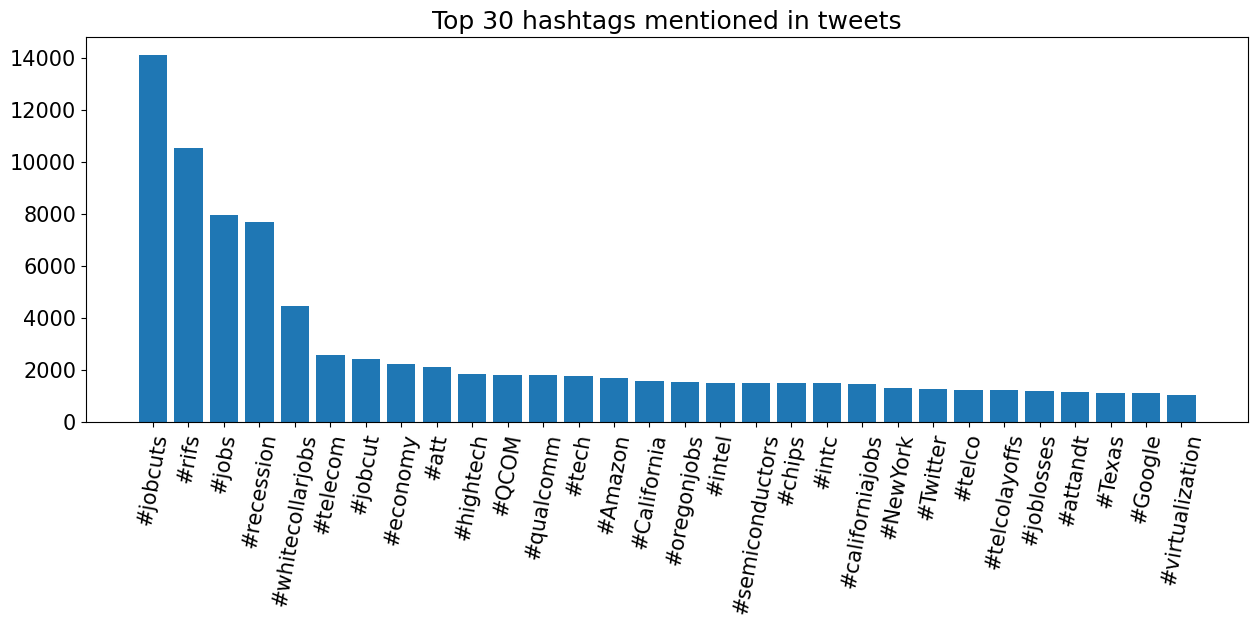

In [8]:
htgs = list(hashtags_dict.keys())[:30]
htg_freqs = list(hashtags_dict.values())[:30]


plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 15})
plt.title("Top 30 hashtags mentioned in tweets")
plt.bar(range(len(htgs)), htg_freqs, tick_label=htgs)
plt.xticks(rotation=80)
plt.show()

### Analysis of unigrams (without hastags)


In [9]:
df_cleaned = df.copy()

def clean_text1(text):
    text = clean(text, no_urls = True ,no_emoji=True, no_emails = True, lower = False, no_currency_symbols=True, no_phone_numbers=True, replace_with_url="", replace_with_currency_symbol="", replace_with_email="", replace_with_phone_number="")
    return text


df_cleaned['Tweet']=df_cleaned['Tweet'].apply(str)

df_cleaned['Tweet']=df_cleaned['Tweet'].apply(lambda z: remove_html(z))
df_cleaned['Tweet']=df_cleaned['Tweet'].apply(lambda z: remove_hashtags(z))
df_cleaned['Tweet']=df_cleaned['Tweet'].apply(lambda z: clean_text1(z))

In [10]:
# # s = "#Layoff Now paying those #bills IS the thing BUT not the end of the journey. Getting #viable job(s) is step one. If for some reason locked out of lifelong employment path working in another direction with #learning be it 4/2/year; technical; gopher or jourrneyman is imperative"
# s = df_cleaned["Tweet"][36]
# print(s)
# print("\n")
# # s.split(" ")

# sw = s.split(" ")
# print(sw)

# reqw = []
    
# # for i in range(len(sw)-1, -1, -1):
# n = len(sw)
# si = 0
# ei = 0
# pi = 0
# tempc = 0
# maxc = 0
# for i in range(n):
    
#     if sw[i].startswith("#") or sw[i].startswith("$") or s in ("", " "):
#         tempc += 1
            
#         if tempc > maxc:
#             maxc = tempc
            
#     else:
#         if tempc == maxc:
#             ei = i
#         tempc = 0
        
# if tempc == maxc:
#     ei = n-1
    
# print("---------------")
# print(ei, sw[ei])
# print(maxc)
# print(ei - maxc, sw[ei - maxc])
# print("---------------")

# for i in range(ei - maxc):
#     reqw.append(sw[i])
# print(reqw)

In [11]:
df_cleaned['Tweet'] = df_cleaned['Tweet'].apply(lambda z: remove_punctuations(z))

In [12]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# A function to remove stopwords from a text
def remove_stopwords(df, column):
    stop_words = set(stopwords.words("english"))
    stop_words.add("see")
    
    def remove_stopwords_from_text(text):
        word_tokens = word_tokenize(text)
        filtered_tokens = [token for token in word_tokens if not token.lower() in stop_words]
        return " ".join(filtered_tokens)
    
    df[column] = df[column].apply(remove_stopwords_from_text)
    return df

df_cleaned = remove_stopwords(df_cleaned, "Tweet")

In [13]:
cleaned_texts = list(df_cleaned["Tweet"])

cleaned_texts_lower = cleaned_texts.copy()
for i in range(len(cleaned_texts_lower)):
    cleaned_texts_lower[i] = cleaned_texts_lower[i].lower()

In [14]:
def get_freq_words(cleaned_texts):
    tot_text = ""
    for t in cleaned_texts:
        tot_text += t
    
    tot_words = tot_text.split(" ")
    
    word_dict = {}
    for w in tot_words:
        if w not in word_dict:
            word_dict[w] = 1

        else:
            word_dict[w] += 1
            
    word_dict = {k: v for k, v in sorted(word_dict.items(), key=lambda item: item[1], reverse = True)}

    return word_dict


word_freq_dict = get_freq_words(cleaned_texts_lower)

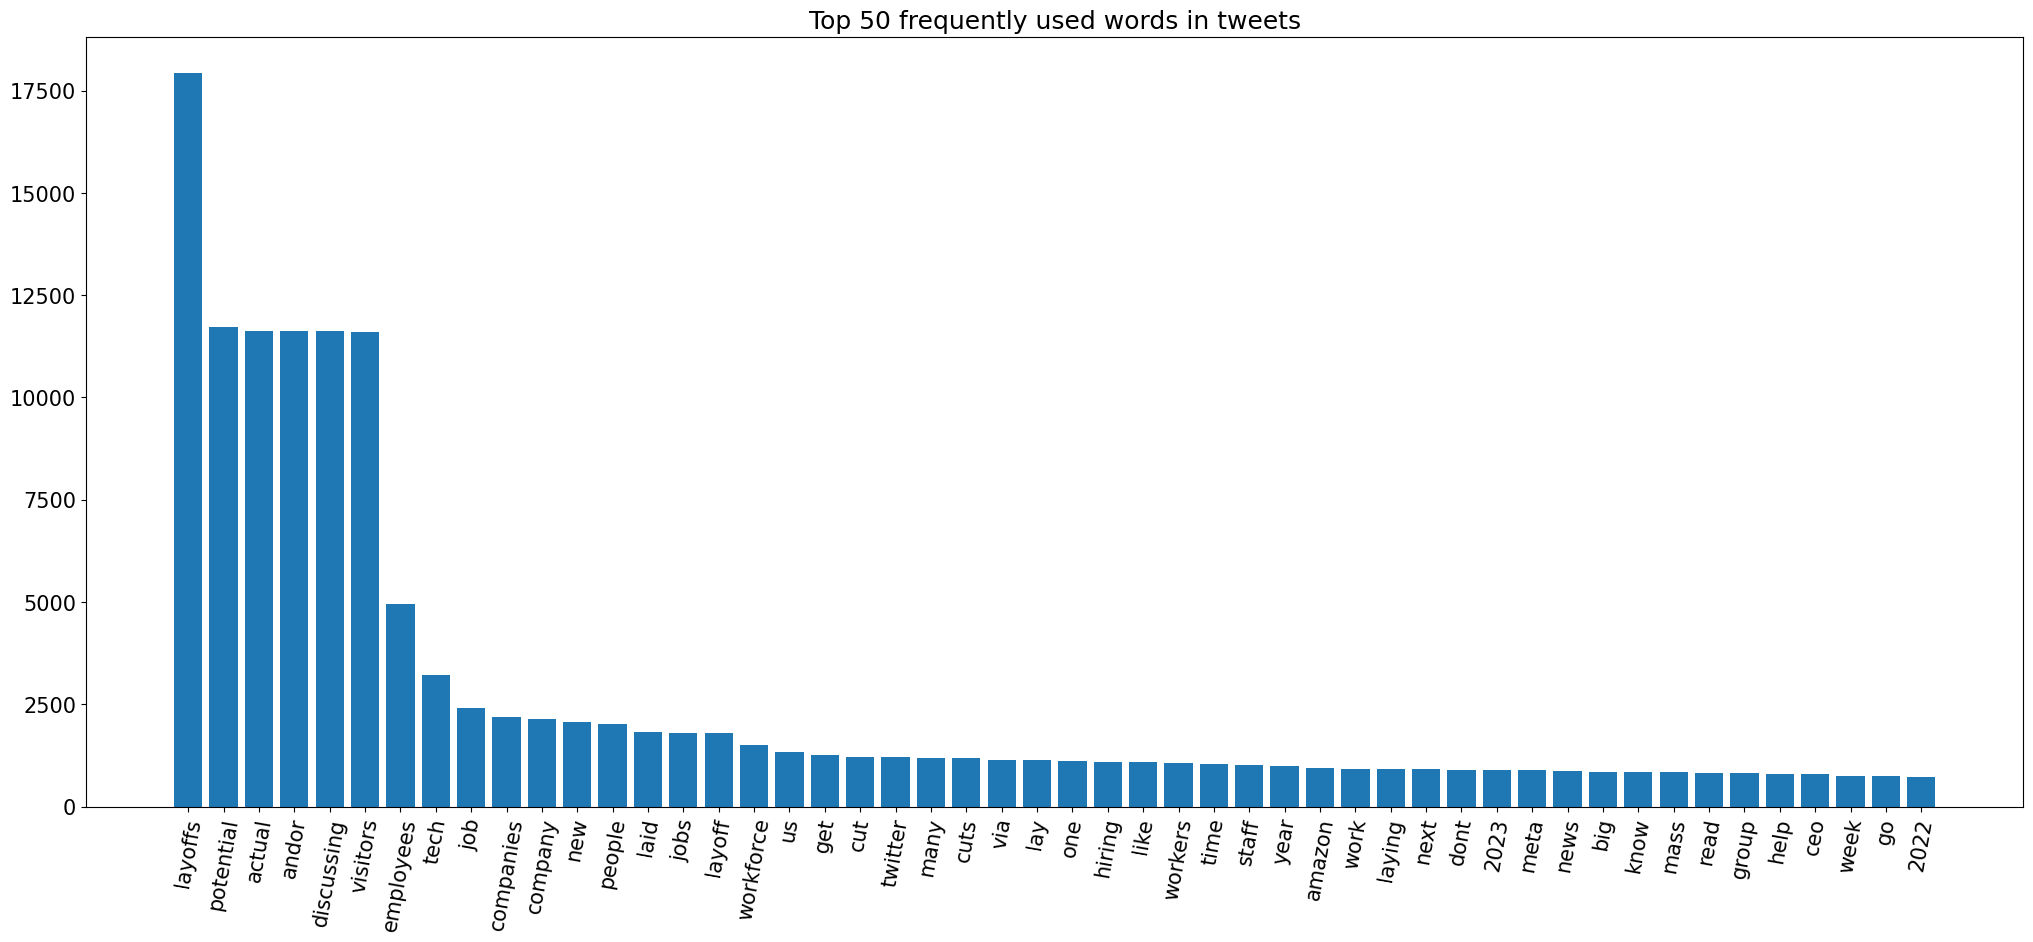

In [15]:
words = list(word_freq_dict.keys())[:50]
word_freqs = list(word_freq_dict.values())[:50]

plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 15})
plt.title("Top 50 frequently used words in tweets")
plt.bar(range(len(words)), word_freqs, tick_label=words)
plt.xticks(rotation=80)
plt.show()

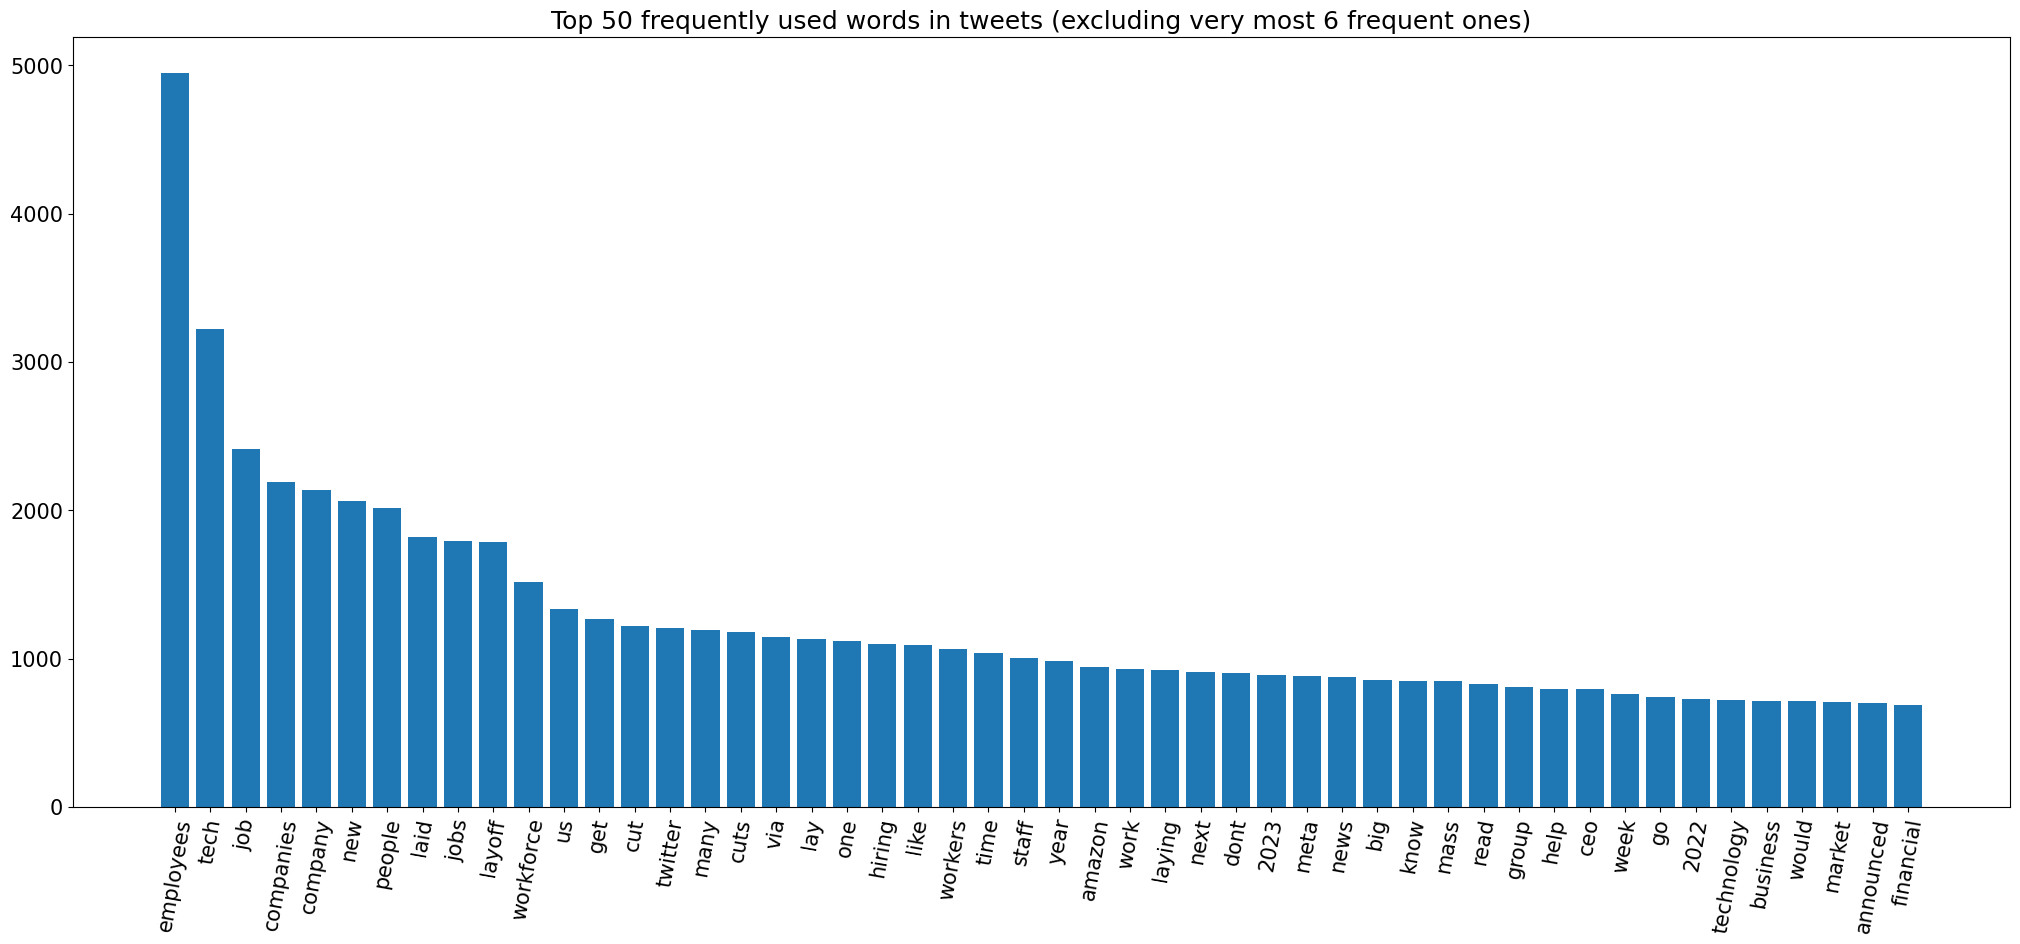

In [16]:
words = list(word_freq_dict.keys())[6:56]
word_freqs = list(word_freq_dict.values())[6:56]

plt.figure(figsize=(25,10))
plt.rcParams.update({'font.size': 15})
plt.title("Top 50 frequently used words in tweets (excluding very most 6 frequent ones)")
plt.bar(range(len(words)), word_freqs, tick_label=words)
plt.xticks(rotation=80)
plt.show()

We could see that words like "twitter" ,"meta", "amazon" freqently mentioned in the tweets, this is probably due to the fact that these top tech companies laid off a lot of a huge no.of employees, which made into the news in the period of mass layoffs.

In [17]:
df1 = df.copy()

df1["Tweet"] = df1["Tweet"].astype(str)

import pandas as pd

# Read the data into a pandas dataframe
# Select the column of LinkedIn posts
posts = df1['Tweet']

# Get the number of non-missing values
num_posts = posts.count()

# Get the mean length of the posts
mean_post_length = posts.str.len().mean()

# Get the median length of the posts
median_post_length = posts.str.len().median()

# Get the standard deviation of the post lengths
stddev_post_length = posts.str.len().std()

# Get the minimum length of the posts
min_post_length = posts.str.len().min()

# Get the maximum length of the posts
max_post_length = posts.str.len().max()

# Calculate the mean number of words in the tweets
mean_num_words = posts.str.split().str.len().mean()
median_num_words = posts.str.split().str.len().median()
stddev_num_words = posts.str.split().str.len().std()


# Print the descriptive statistics
print("Some Descriptive Stats about Tweets:- \n")
print("Number of tweets: ", num_posts)
print("Mean no.of characters of tweets: ", mean_post_length)
print("Median no.of characters of tweets: ", median_post_length)
print("Standard deviation of tweets lengths: ", stddev_post_length)
print("Minimum length of tweets: ", min_post_length)
print("Maximum length of tweets: ", max_post_length)
print()
print("Mean number of words in tweets:", int(mean_num_words))
print("Median no.of of words in tweets:", int(median_num_words))
print("Standard deviation of words in tweets:", int(stddev_num_words))
print()

Some Descriptive Stats about Tweets:- 

Number of tweets:  55404
Mean no.of characters of tweets:  207.97884629268646
Median no.of characters of tweets:  217.0
Standard deviation of tweets lengths:  59.41788007074791
Minimum length of tweets:  1
Maximum length of tweets:  346

Mean number of words in tweets: 26
Median no.of of words in tweets: 27
Standard deviation of words in tweets: 8



/var/folders/3q/txm7h4896k7f8pcsm9l619lh0000gn/T/ipykernel_71049/2504392174.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pl, kde=False, bins=40)


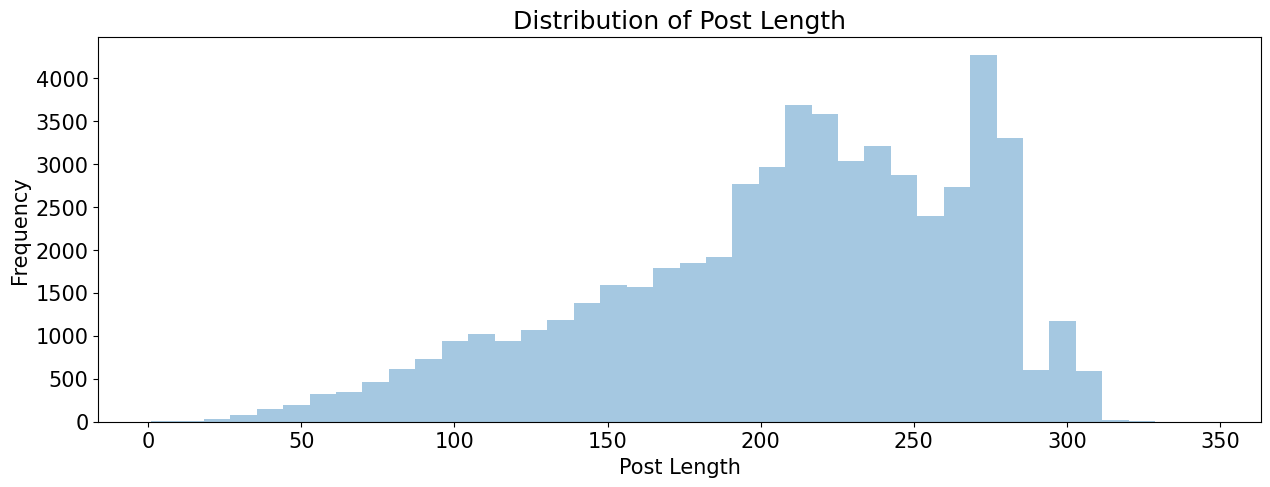

In [18]:
df_pl = df1['Tweet'].apply(lambda x: len(x))
plt.figure(figsize = (15,5))
sns.distplot(df_pl, kde=False, bins=40)
plt.xlabel("Post Length")
plt.ylabel("Frequency")
plt.title("Distribution of Post Length")
plt.show()

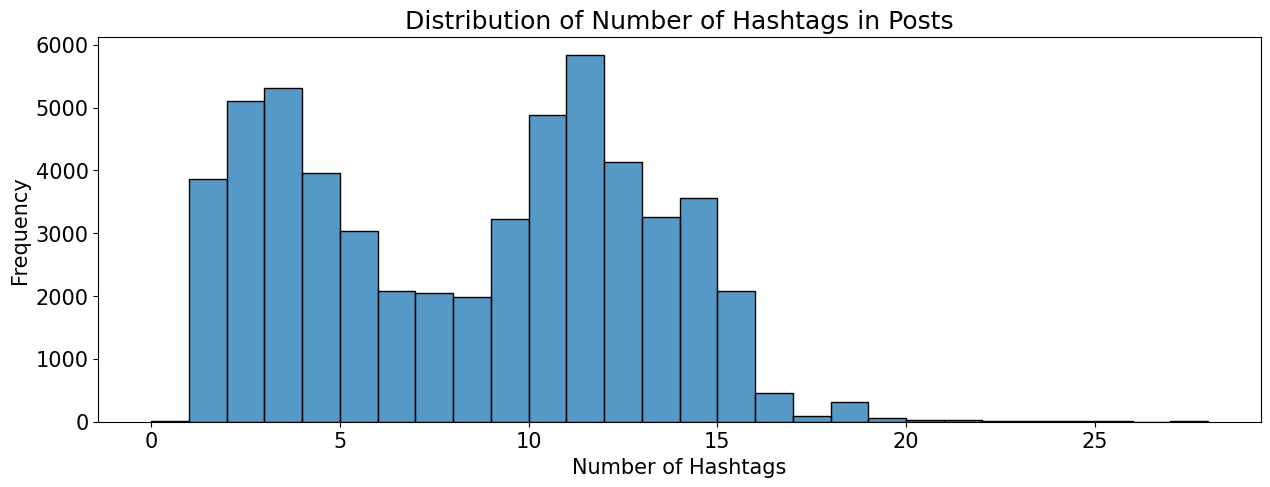

In [19]:
df_hash = df["Tweet"].apply(lambda x: str(x).count("#"))
plt.figure(figsize = (15,5))
sns.histplot(df_hash, kde=False, bins=max(df_hash))
plt.title("Distribution of Number of Hashtags in Posts")
plt.xlabel("Number of Hashtags")
plt.ylabel("Frequency")
plt.show()

# **Chronological analysis of tweets**
## Analysis of tweets based on time

In [20]:
df1 = df.copy()

df1 = df1[df1["Date"].isna() == False]
df1.reset_index(inplace=True)

In [21]:
del df1["index"]

## Timestamps at which most tweets are being posted in a day

### Hour-wise analysis

In [22]:
def get_time_posted(date):
    date = date.split(" ")
    if len(date) < 2:
        return None
    time = date[1]
    return time

df1["time"] = df1["Date"].apply(lambda z:get_time_posted(z))

In [23]:
def get_date_posted(date):
    date = date.split(" ")
    if len(date) < 2:
        return None
    time = date[0]
    return time

df1["date_p"] = df1["Date"].apply(lambda z:get_date_posted(z))

In [24]:
df1 = df1[df1["date_p"].isna() == False]
df1['time'] = pd.to_datetime(df1['time'])
df1["hour"] = df1["time"].apply(lambda z:z.hour)

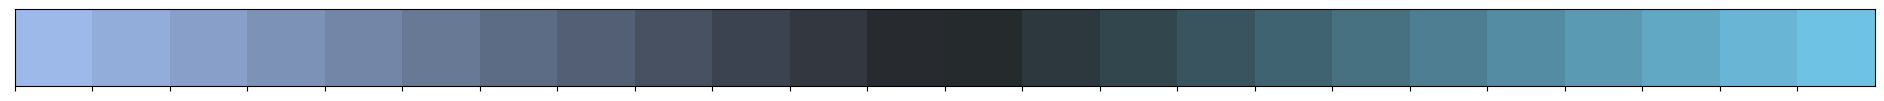

In [25]:
custom_cmap = sns.diverging_palette(h_pos= 225, h_neg = 250, s = 70 , l=75,n = 24, sep = 2 ,center="dark")
sns.palplot(custom_cmap)
plt.show()

/var/folders/3q/txm7h4896k7f8pcsm9l619lh0000gn/T/ipykernel_71049/433567380.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1["hour"], color='#0f9c60', shade=True, linewidth=1.5, ec='black',alpha=0.75, zorder=2, legend=False)


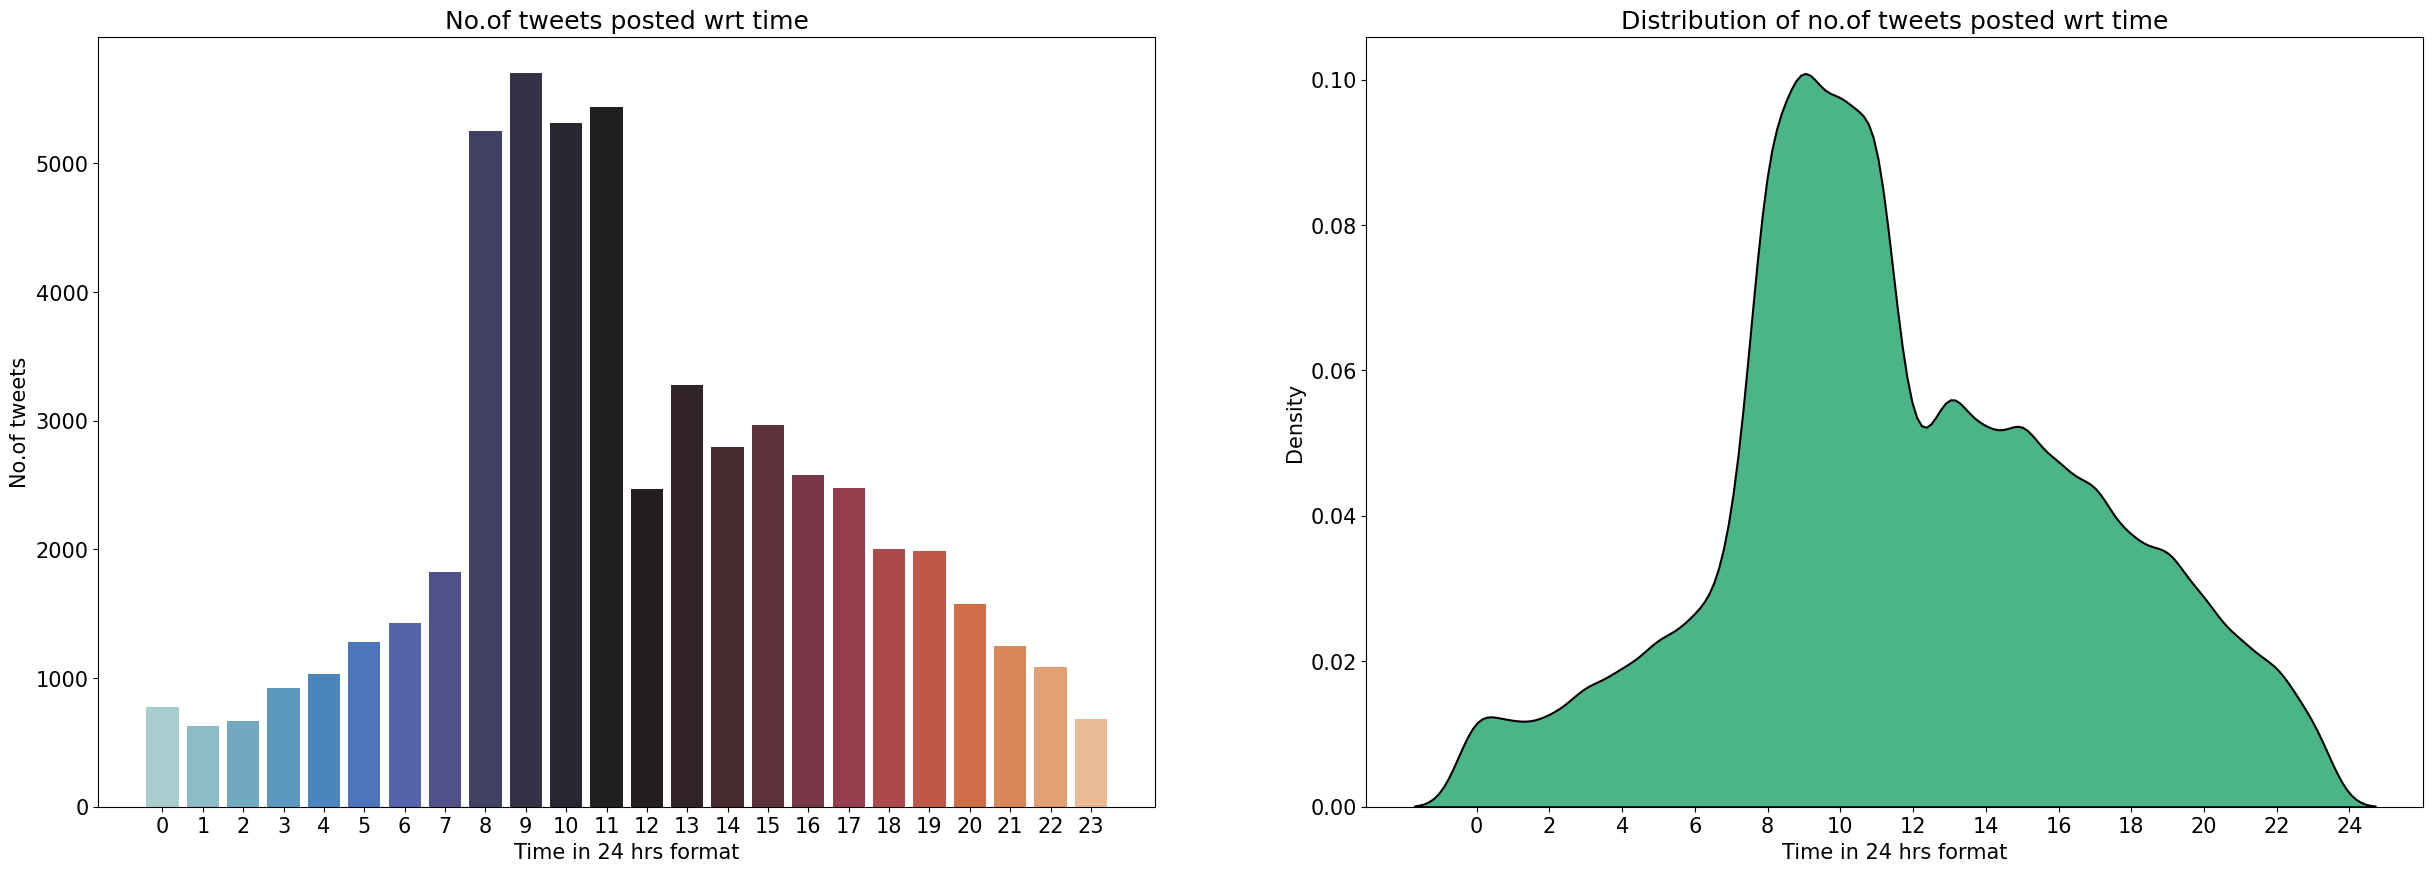

In [26]:
plt.figure(figsize = (30, 10))
# sns.countplot(df["hour"], palette=custom_cmap)
plt.subplot(1,2,1)
sns.countplot(x = df1["hour"], palette=sns.color_palette("icefire", 24))
plt.xlabel("Time in 24 hrs format")
plt.ylabel("No.of tweets")
plt.title("No.of tweets posted wrt time")
plt.plot()


plt.subplot(1,2,2)
sns.kdeplot(df1["hour"], color='#0f9c60', shade=True, linewidth=1.5, ec='black',alpha=0.75, zorder=2, legend=False)
plt.xlabel("Time in 24 hrs format")
plt.title("Distribution of no.of tweets posted wrt time")
time_axis = [2*i for i in range(13)]
plt.xticks(time_axis)

plt.plot()

plt.show()

### Observation:-

**We could see that a lot of the tweets are posted in between 8am to 12pm, which genreally is the starting time of many workplaces all around the world, and as expected, the activity is low as it becomes night.**

### Weekly distribution of tweets about layoffs (from the starting day)

In [27]:
def get_num_tweets(df, df_name):
    
    op_dict = {}
    
    sm = 9
    em = 10
    curr_year = 2022
    
    sy = curr_year
    ey = curr_year
    for i in range(4):
        
        if em > 12:
            em = 1
            ey += 1
            
        if sm > 12:
            sm = 1
            sy += 1
        
        if sm < 10:
            sd = str(sy)+"-0" + str(sm) + "-01"
        else:
            sd = str(sy)+"-"+str(sm)+"-" + "01"
            
        if em < 10:
            ed = str(ey)+"-0" + str(em) + "-01"
        else:
            ed = str(ey)+"-"+str(em)+"-" + "01"
            
        sm += 1
        em += 1
    
        query = '''SELECT COUNT(*) AS num_tweets FROM {} WHERE Date BETWEEN '{}' AND '{}' ''';
        query_f = query.format(df_name, sd, ed)
        op_df = duckdb.query(query_f).to_df()
        
        print(op_df)
#         op_df = sqldf(q)        
        key = query_f.split("BETWEEN ")[1]
        op_dict[key] = int(op_df["num_tweets"])
        
    return op_dict

In [28]:
mw_tweet_dict = get_num_tweets(df1, "df1")
mw_tweet_dict

   num_tweets
0        1701
   num_tweets
0        6041
   num_tweets
0       13007
   num_tweets
0       15578


{"'2022-09-01' AND '2022-10-01' ": 1701,
 "'2022-10-01' AND '2022-11-01' ": 6041,
 "'2022-11-01' AND '2022-12-01' ": 13007,
 "'2022-12-01' AND '2023-01-01' ": 15578}

In [29]:
def get_num_tweets(df, df_name):
    
    op_dict = {}
    
    sm = 9
    em = 10
    curr_year = 2022
    
    sy = curr_year
    ey = curr_year
    for i in range(4):
        
        if em > 12:
            em = 1
            ey += 1
            
        if sm > 12:
            sm = 1
            sy += 1
        
        if sm < 10:
            sd = str(sy)+"-0" + str(sm) + "-01"
        else:
            sd = str(sy)+"-"+str(sm)+"-" + "01"
            
        if em < 10:
            ed = str(ey)+"-0" + str(em) + "-01"
        else:
            ed = str(ey)+"-"+str(em)+"-" + "01"
            
        sm += 1
        em += 1
    
        query = '''SELECT COUNT(*) AS num_tweets FROM {} WHERE Date BETWEEN '{}' AND '{}';''';
        query_f = query.format(df_name, sd, ed)
        op_df = duckdb.query(query_f).to_df()

        key = query_f.split("BETWEEN ")[1]
        op_dict[key] = int(op_df["num_tweets"])
        
    return op_dict

In [30]:
def get_week_wise_tcount(df, month, year, df_name):
    
    op_dict = {}
    curr_year = year
    
    st_day = 1
    end_day = 7
    for i in range(4):
        
        if i == 3:
            end_day = 31
            if month < 10:
            
                if st_day < 10:
                    sd = str(year)+ "-0" + str(month) + "-0" + str(st_day)

                else:
                    sd = str(year)+ "-0" +str(month) + "-" + str(st_day)


                if end_day < 10:
                    ed = str(year)+ "-0" + str(month) + "-0" + str(end_day)

                else:
                    ed = str(year)+ "-0" +str(month) + "-" + str(end_day)

                
            else:

                if st_day < 10:
                    sd = str(year)+"-" + str(month) + "-0" + str(st_day)

                else:
                    sd = str(year)+"-" + str(month)+"-" + str(st_day)


                if end_day < 10:
                    ed = str(year)+ "-" + str(month) + "-0" + str(end_day)

                else:
                    ed = str(year)+ "-" +str(month)+"-" + str(end_day)
                    
            
            query = '''SELECT COUNT(*) AS num_tweets FROM {} WHERE Date BETWEEN '{}' AND '{}';''';
            query_f = query.format(df_name, sd, ed)
            op_df = duckdb.query(query_f).to_df()


            key = query_f.split("BETWEEN ")[1]
            op_dict[key] = int(op_df["num_tweets"])
            
            return op_dict

        
        if month < 10:
            
            if st_day < 10:
                sd = str(year)+ "-0" + str(month) + "-0" + str(st_day)
                
            else:
                sd = str(year)+ "-0" +str(month) + "-" + str(st_day)
                
            
            if end_day < 10:
                ed = str(year)+ "-0" + str(month) + "-0" + str(end_day)
                
            else:
                ed = str(year)+ "-0" +str(month) + "-" + str(end_day)
            
                
        else:
            
            if st_day < 10:
                sd = str(year)+"-" + str(month) + "-0" + str(st_day)
                
            else:
                sd = str(year)+"-" + str(month)+"-" + str(st_day)
            
            
            if end_day < 10:
                ed = str(year)+ "-" + str(month) + "-0" + str(end_day)
                
            else:
                ed = str(year)+ "-" +str(month)+"-" + str(end_day)
            
            
                    
        query = '''SELECT COUNT(*) AS num_tweets FROM {} WHERE Date BETWEEN '{}' AND '{}';''';
        query_f = query.format(df_name, sd, ed)
        op_df = duckdb.query(query_f).to_df()
#   
        key = query_f.split("BETWEEN ")[1]
        op_dict[key] = int(op_df["num_tweets"])
        
        
        st_day = end_day + 1
        end_day += 7
        
        

In [31]:
get_week_wise_tcount(df1, 10, 2022, "df1")

{"'2022-10-01' AND '2022-10-07';": 561,
 "'2022-10-08' AND '2022-10-14';": 1098,
 "'2022-10-15' AND '2022-10-21';": 1362,
 "'2022-10-22' AND '2022-10-31';": 2019}

In [32]:
def get_monthly_week_tc(df, year, sm, em, df_name):
    
    op_dict = {}
    
    for m in range(sm,em+1):
        
        op_dict[m] = get_week_wise_tcount(df, m, year,df_name)
    return op_dict

In [33]:
mw_2022_dict = get_monthly_week_tc(df1, 2022, 9, 12, "df1")
mw_2022_dict

{9: {"'2022-09-01' AND '2022-09-07';": 231,
  "'2022-09-08' AND '2022-09-14';": 240,
  "'2022-09-15' AND '2022-09-21';": 367,
  "'2022-09-22' AND '2022-09-31';": 647},
 10: {"'2022-10-01' AND '2022-10-07';": 561,
  "'2022-10-08' AND '2022-10-14';": 1098,
  "'2022-10-15' AND '2022-10-21';": 1362,
  "'2022-10-22' AND '2022-10-31';": 2019},
 11: {"'2022-11-01' AND '2022-11-07';": 2287,
  "'2022-11-08' AND '2022-11-14';": 3563,
  "'2022-11-15' AND '2022-11-21';": 2718,
  "'2022-11-22' AND '2022-11-31';": 2789},
 12: {"'2022-12-01' AND '2022-12-07';": 2106,
  "'2022-12-08' AND '2022-12-14';": 3482,
  "'2022-12-15' AND '2022-12-21';": 3575,
  "'2022-12-22' AND '2022-12-31';": 3555}}

In [34]:
mw_2023_dict = get_monthly_week_tc(df1, 2023, 1, 2, "df1")
mw_2023_dict

{1: {"'2023-01-01' AND '2023-01-07';": 2491,
  "'2023-01-08' AND '2023-01-14';": 2870,
  "'2023-01-15' AND '2023-01-21';": 6978,
  "'2023-01-22' AND '2023-01-31';": 5208},
 2: {"'2023-02-01' AND '2023-02-07';": 0,
  "'2023-02-08' AND '2023-02-14';": 0,
  "'2023-02-15' AND '2023-02-21';": 0,
  "'2023-02-22' AND '2023-02-31';": 0}}

In [35]:
df1["Date"] = pd.to_datetime(df1['Date'])
df1_copy = df1.copy()

df1_copy.index = df1_copy['Date']

## Calender plots (Heatmaps) of the data acquired 

In [36]:
import calplot

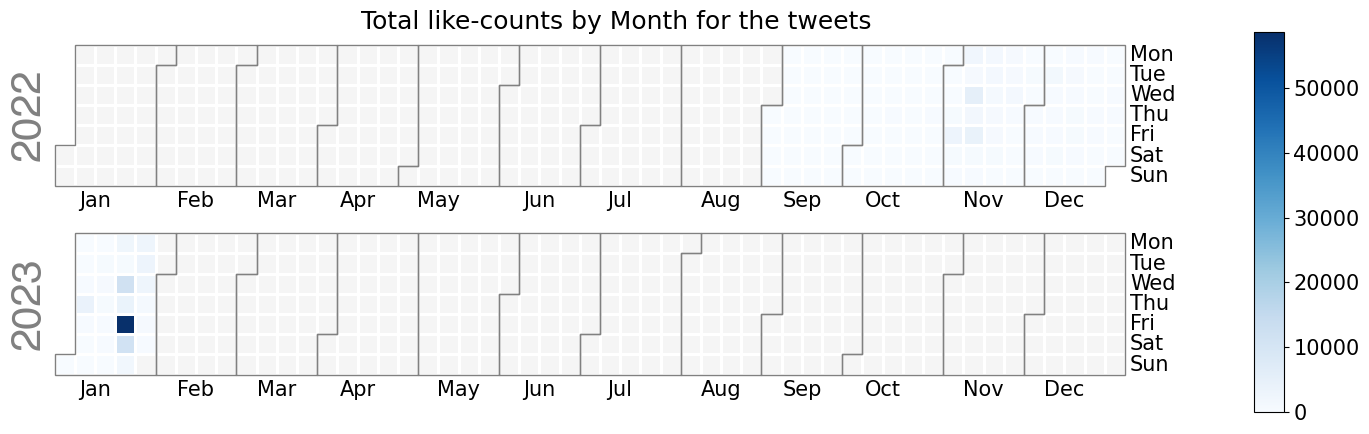

In [37]:
pl1 = calplot.calplot(data = df1_copy['likeCount'],how = 'sum', cmap = 'Blues', figsize = (15, 4), suptitle = "Total like-counts by Month for the tweets")



In [38]:
query = '''
SELECT date_p, COUNT(*) AS num_tweets FROM df1 GROUP BY date_p ORDER BY date_p ASC;
'''

num_tweets_pd_df = duckdb.query(query).to_df()

In [39]:
num_tweets_pd_df["date_p"] = pd.to_datetime(num_tweets_pd_df['date_p'])
num_tweets_pd_df.index = num_tweets_pd_df['date_p']

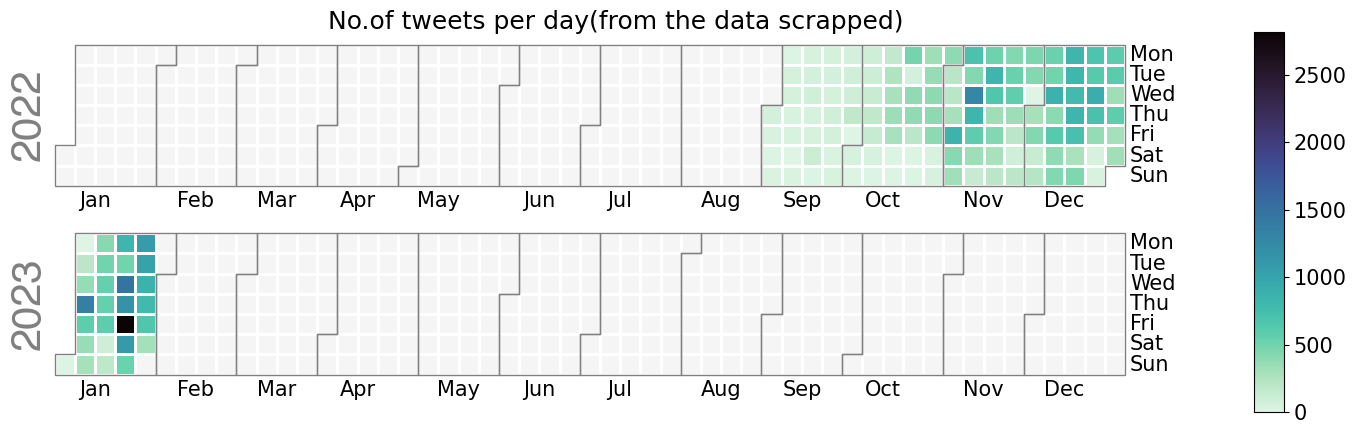

In [40]:
pl2 = calplot.calplot(data = num_tweets_pd_df['num_tweets'],how = 'sum', cmap = 'mako_r', figsize = (15, 4), suptitle = "No.of tweets per day(from the data scrapped)")


In [41]:
def remove_emoji(text):
    text = clean(text,no_emoji=True, lower = False)
    return text

def get_isabout_comp(text, search_w):
    
    text = remove_hashsymbol(text)
    text = (text)
    text = remove_html(text)

    text = text.lower()
    
    for sw in search_w: 
        if sw in text:
            return True
    
    return False
    
    
def get_num_tweets_company(df, company):
    compname = company
    company = company.lower()
    
    company = company.split(" ")
    
    search_w = []
    if len(company) > 1:
        
        w1 = ""
        w2 = ""
        for w in company:
            w1 += w
            w2 += w
            w2 += " "
            
        search_w.append(w1)
        search_w.append(w2)

        
    else:
        search_w.append(company[0])
        
        
    num_tweets_comp = []
    
    for i in range(len(df)):
        if get_isabout_comp(df.iloc[i]["Tweet"], search_w):
            num_tweets_comp.append(1)
        else:
            num_tweets_comp.append(0)
            
    df1_copy[compname] = num_tweets_comp


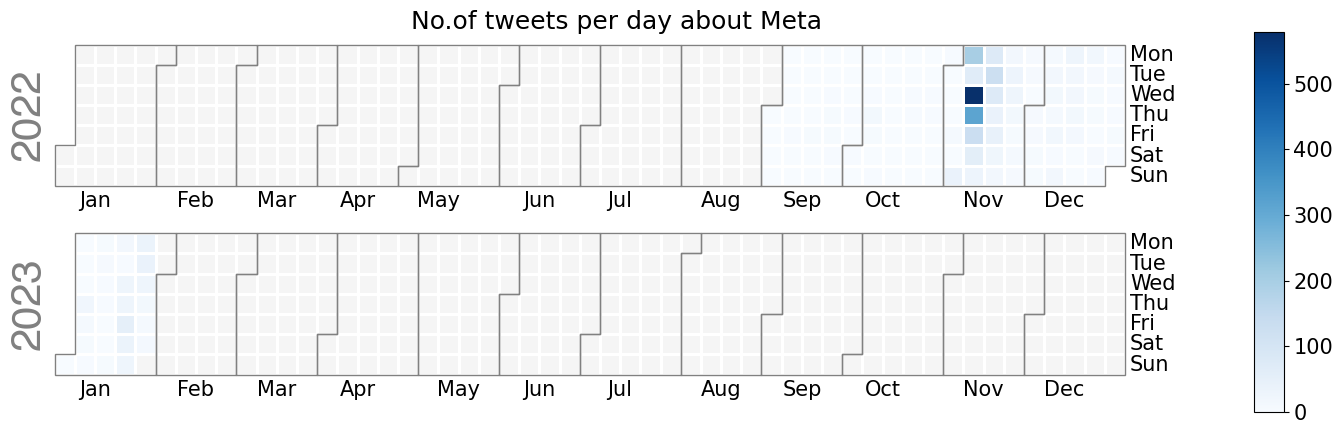

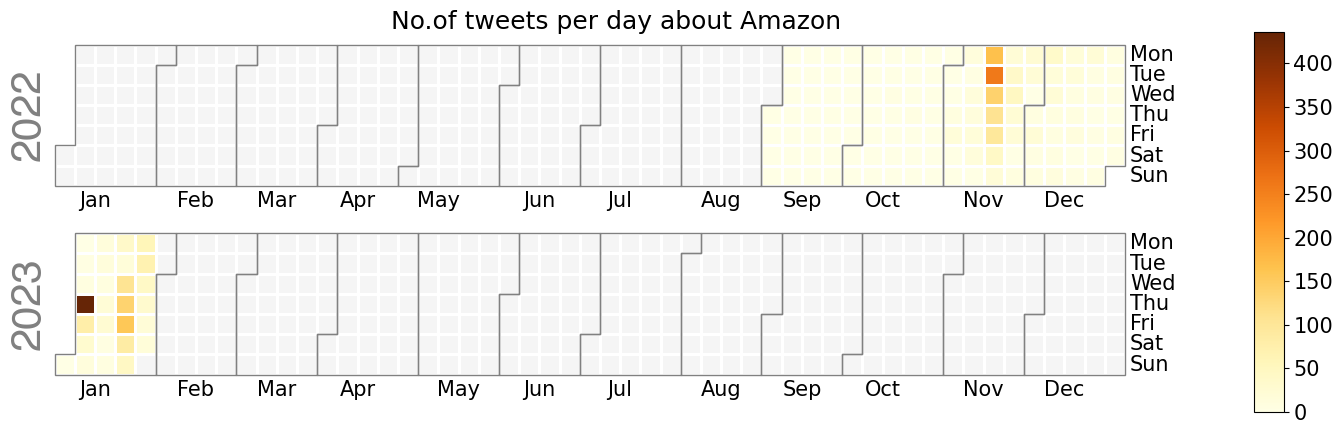

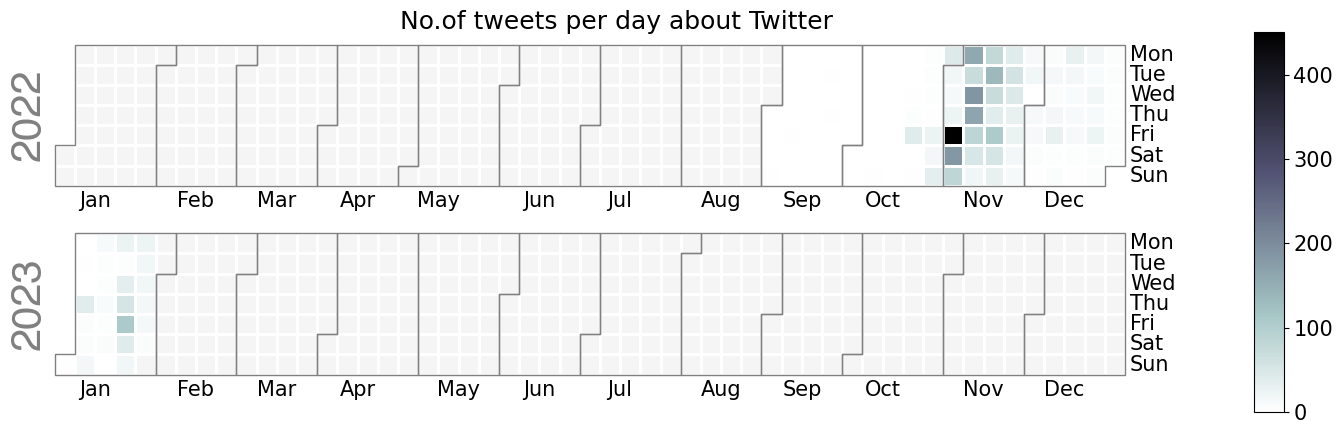

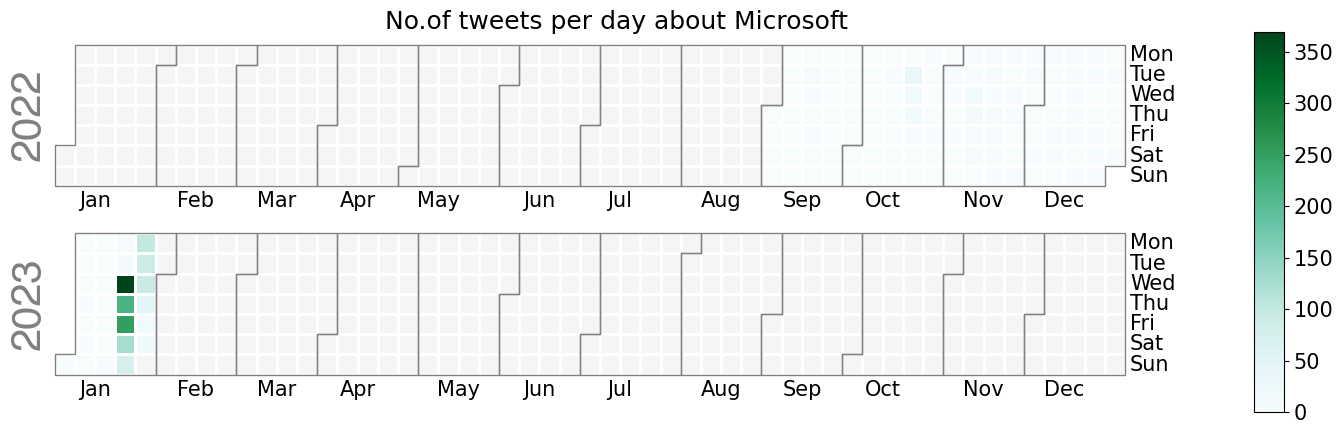

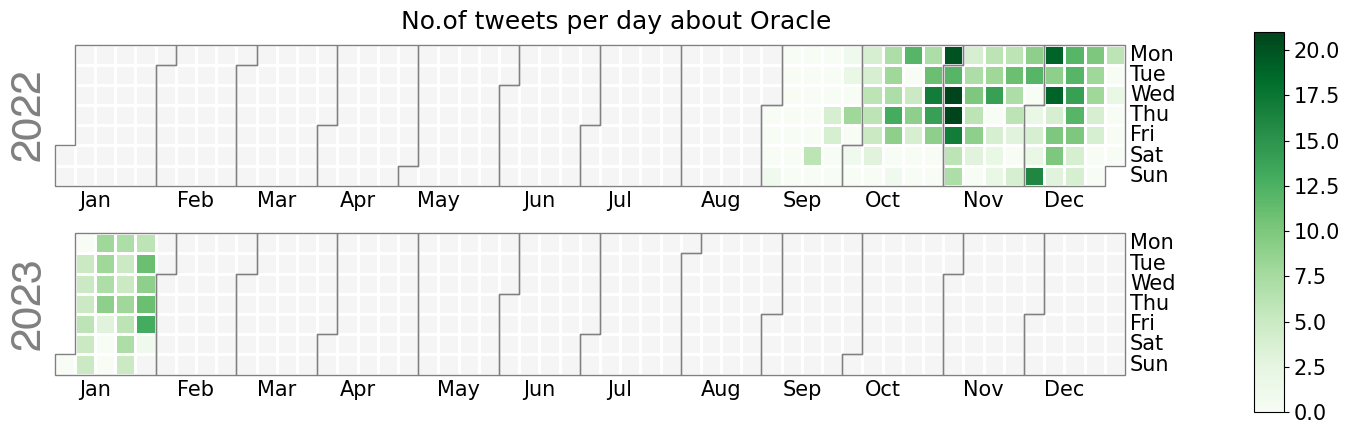

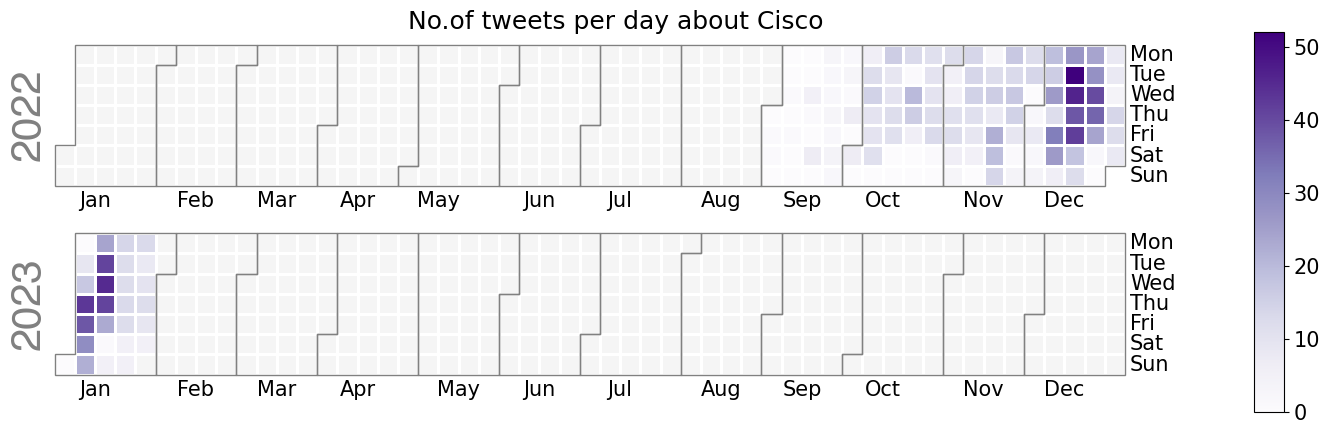

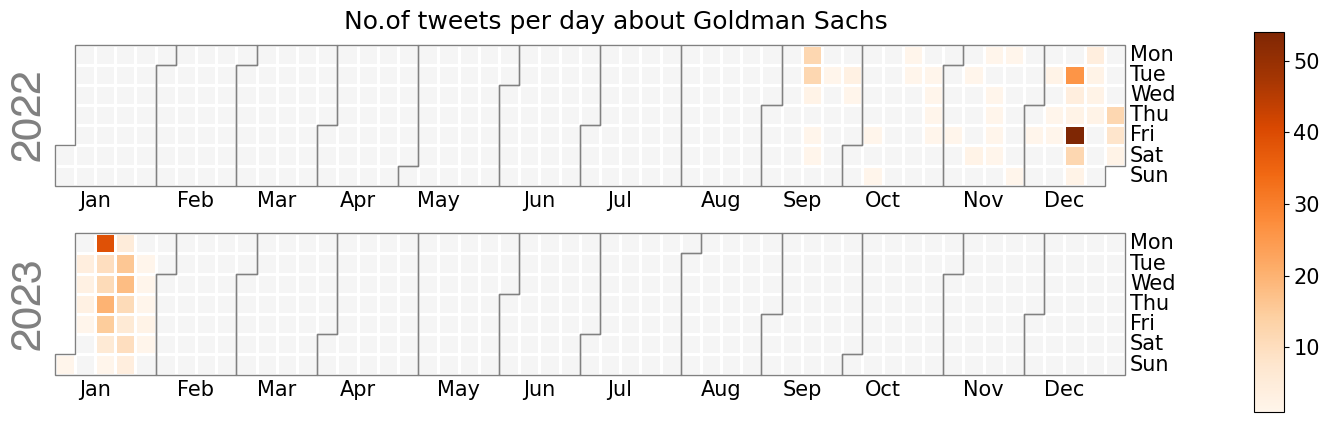

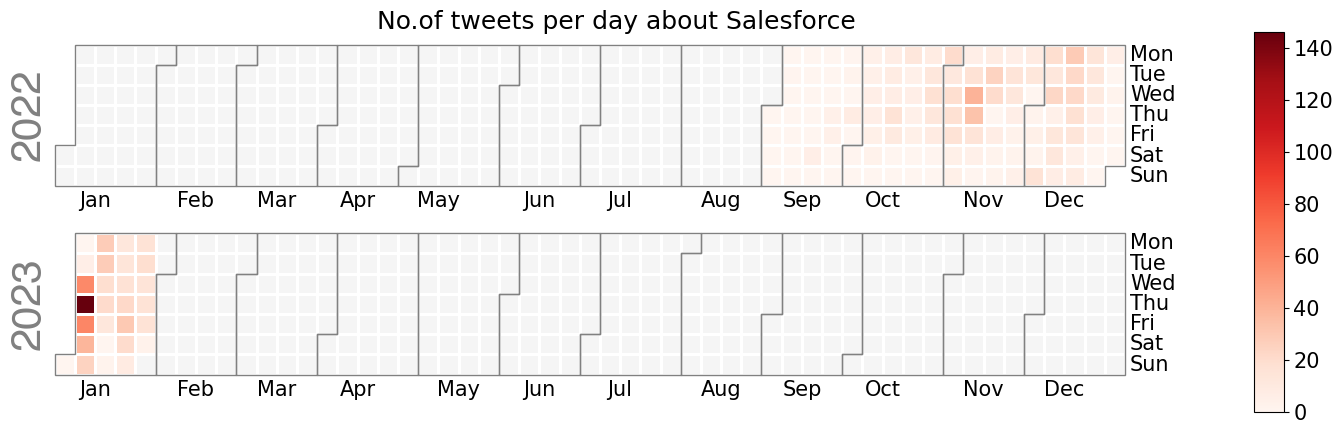

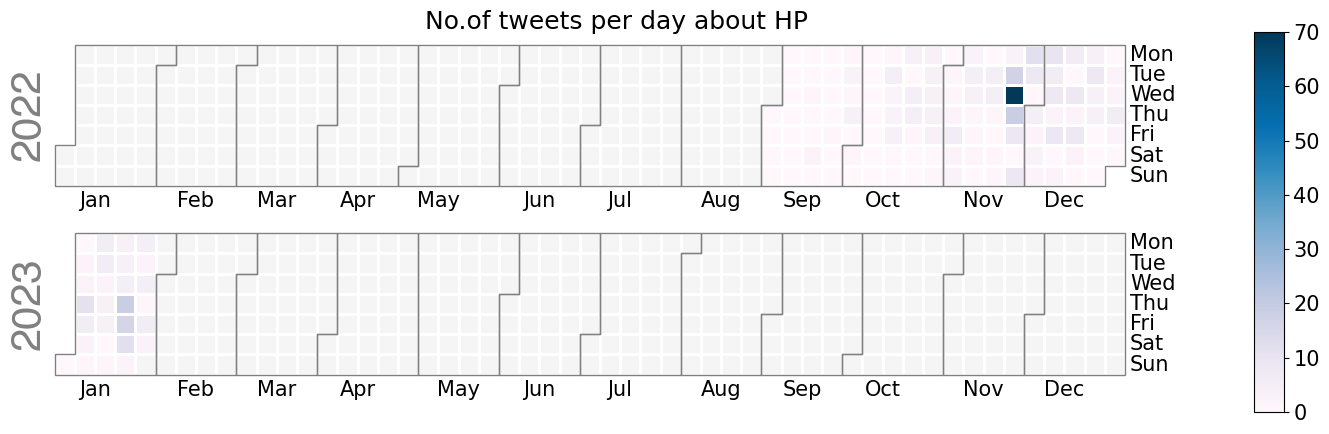

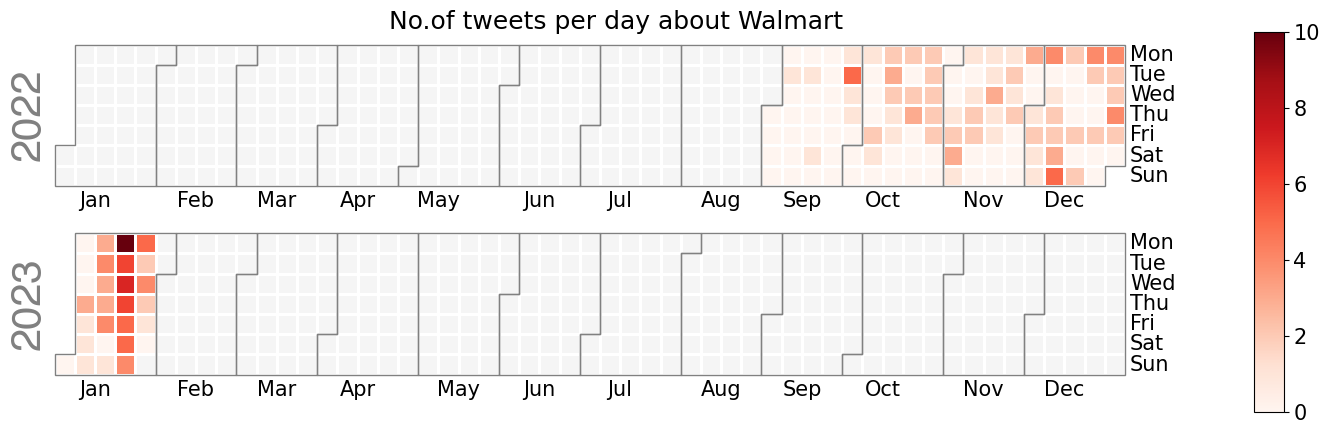

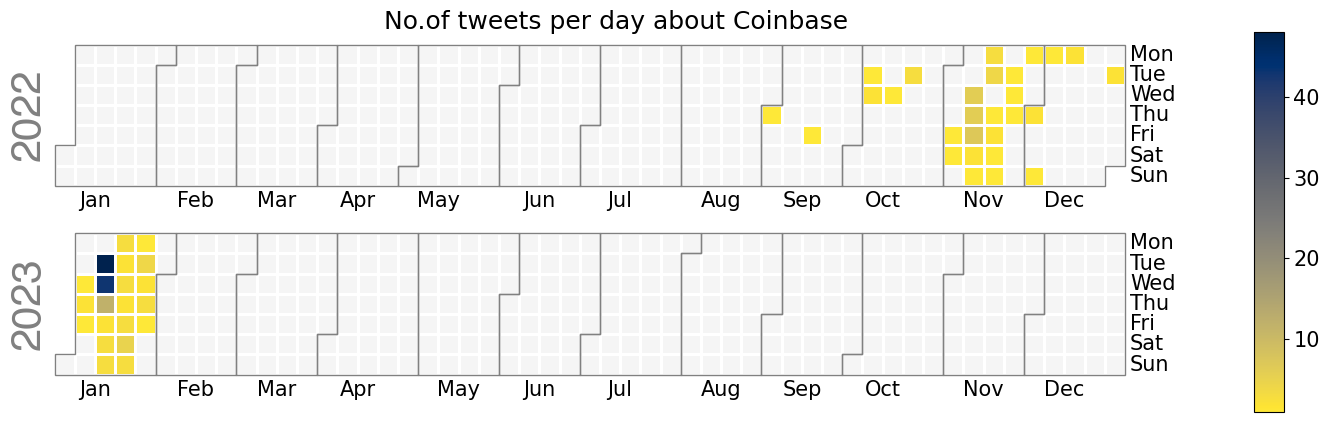

In [42]:
def comp_timelines_heatmap(df, companies, colors):
    
    i = 0
    for comp in companies:
        get_num_tweets_company(df1_copy, comp)
        pl2 = calplot.calplot(data = df1_copy[comp],how = 'sum', cmap = colors[i], figsize = (15, 4), suptitle = "No.of tweets per day" + " about "+ comp)
        i += 1


companies = ["Meta", "Amazon", "Twitter", "Microsoft", "Oracle", "Cisco", "Goldman Sachs", "Salesforce", "HP", "Walmart", "Coinbase"]
colors = ["Blues", "YlOrBr", "bone_r", "BuGn", "Greens", "Purples", "Oranges", "Reds", "PuBu", "Reds", "cividis_r"]
comp_timelines_heatmap(df1_copy, companies, colors)

### Observation:- 
**We could see the timelines and trends for each company from sept 2022 till the present time. This could potentially give us a visualzation of the layoff-waves, as the no.of tweets about that particular comapny would be high whenever the company fires some part of it's workforce.**

The same is done in the next part, this time woth histograms, rather than calender plots, for visualising the peaks and waves better.

## **Histograms of the no.of tweets for each company (in chronological order)**


In [43]:
df1_copy_indfix = df1_copy.copy()

In [44]:
temp = df1_copy_indfix[df1_copy_indfix["Amazon"] == 1].groupby("date_p")
tempc = temp.count()

# tempc.loc['2022-08-01']


'2022-08-01' in tempc.index

False

In [45]:
tempc["Tweet"]

date_p
2022-09-01     2
2022-09-04     1
2022-09-07     1
2022-09-09     1
2022-09-12     1
              ..
2023-01-24    69
2023-01-25    41
2023-01-26    31
2023-01-27    20
2023-01-28    17
Name: Tweet, Length: 119, dtype: int64

In [46]:
temp_df = pd.DataFrame(df1_copy_indfix['Date'].dt.date)
temp_df.index = [i for i in range(len(temp_df))]
    
q = '''
        SELECT DISTINCT(Date) AS date FROM temp_df
    '''
all_dates_df = duckdb.query(q).to_df()

# all_dates_df

In [47]:
df1_copy_indfix.index = [i for i in range(len(df1_copy_indfix))]

In [48]:
def get_num_tweets_hist_comp(df1_copy_indfix, companies):
    
    comp_hist = {}

    temp_df = pd.DataFrame(df1_copy_indfix['Date'].dt.date)
    temp_df.index = [i for i in range(len(temp_df))]
    
    q = '''
        SELECT DISTINCT(Date) AS date FROM temp_df
    '''
    all_dates_df = duckdb.query(q).to_df()
    
    for cname in companies:
        
        temp = df1_copy_indfix[df1_copy_indfix[cname] == 1].groupby("date_p")
        tempc = temp.count()
    
        comp_arr = [0]*len(all_dates_df)
        
        for i in range(len(all_dates_df)):
            curr_date = all_dates_df.iloc[i]["date"]
            if str(curr_date.date()) in tempc.index:
                comp_arr[i] = tempc.loc[str(curr_date.date())]["Tweet"]
        
        comp_hist[cname] = comp_arr
        
    return comp_hist


In [49]:
companies = ["Meta", "Amazon", "Twitter", "Microsoft", "Oracle", "Cisco", "Goldman Sachs", "Salesforce", "HP", "Walmart", "Coinbase"]

comp_hist_dict = get_num_tweets_hist_comp(df1_copy_indfix, companies)

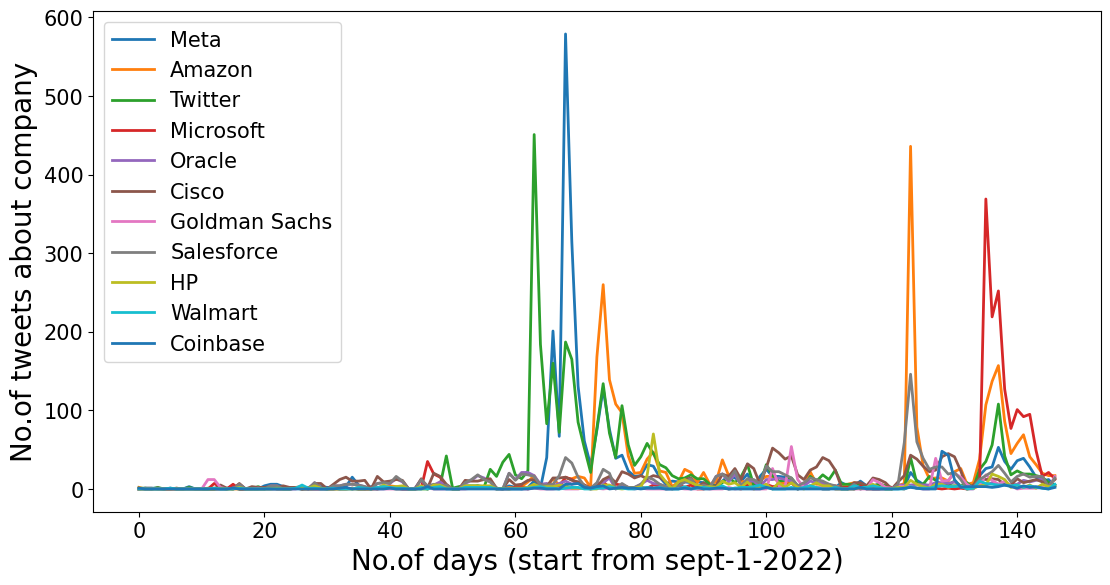

In [50]:
plt.figure(figsize=(13,6.5))

for k in comp_hist_dict.keys():
    
    plt.plot(comp_hist_dict[k], label= k, linewidth = 2)
    
    
plt.legend(loc='best')
plt.xlabel("No.of days (start from sept-1-2022)", fontsize = 20)
plt.ylabel("No.of tweets about company", fontsize = 20)
plt.show()

In [51]:
def moving_average(data):
    moving_average = []
    for i in range(len(data)):
        if i + 7 < len(data):
            moving_average.append(np.mean(data[i:i+7]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

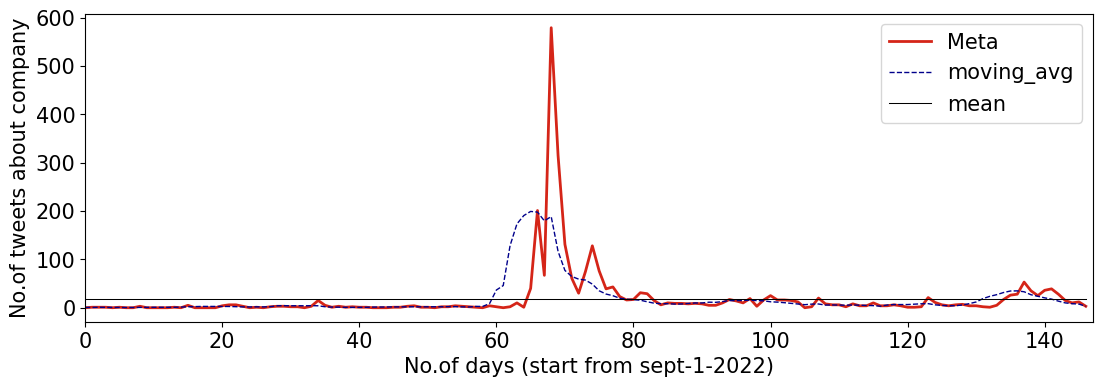

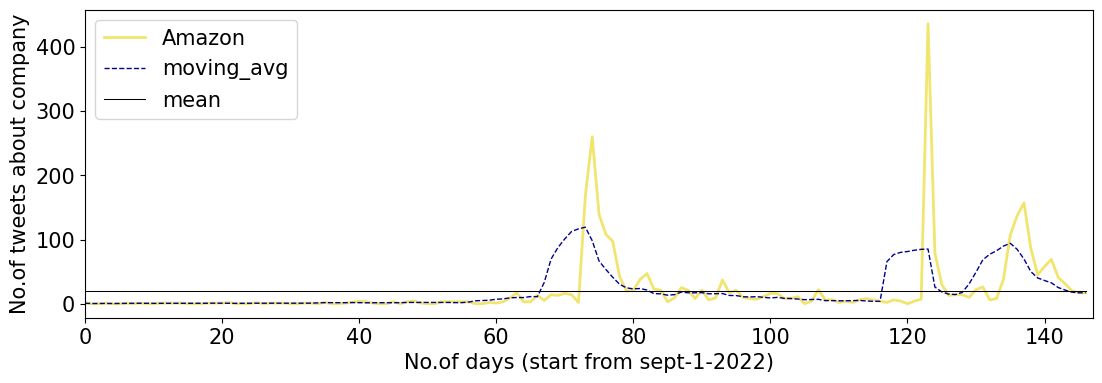

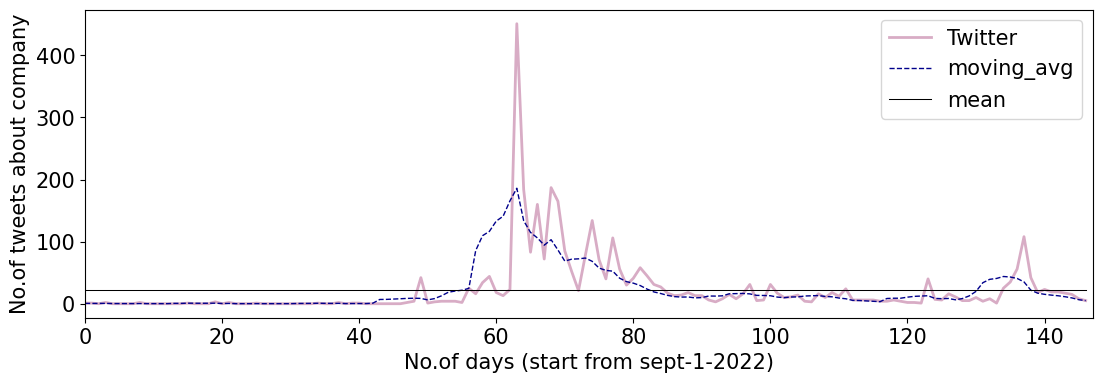

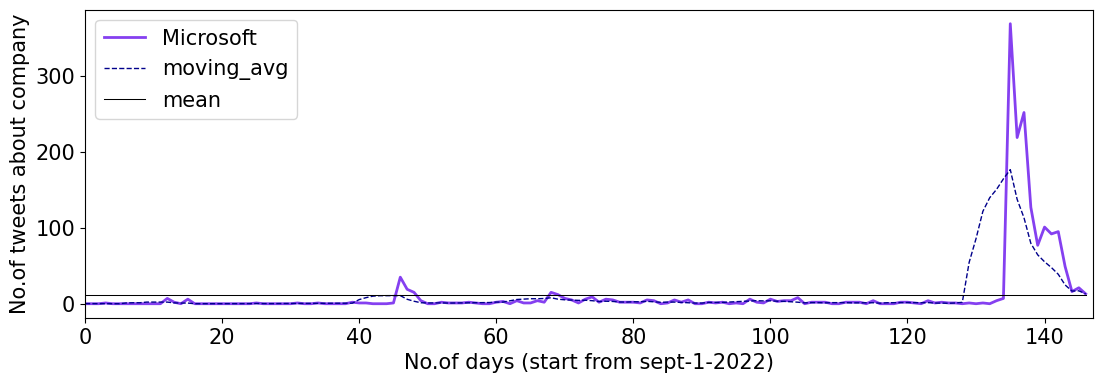

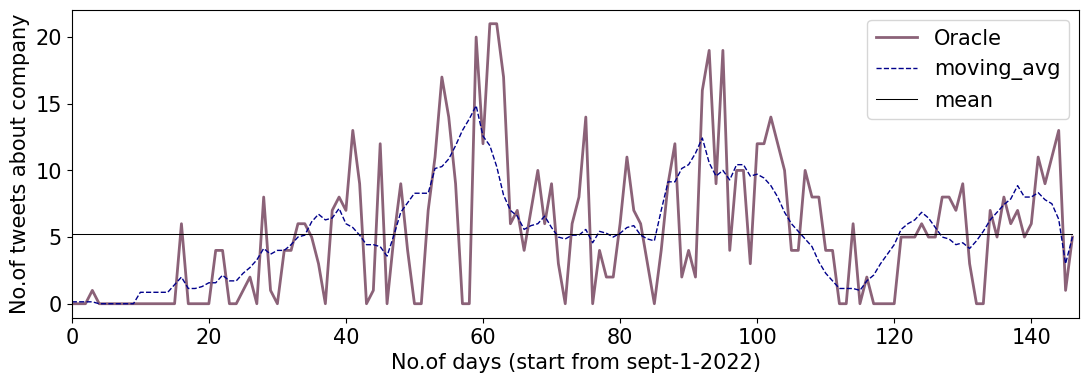

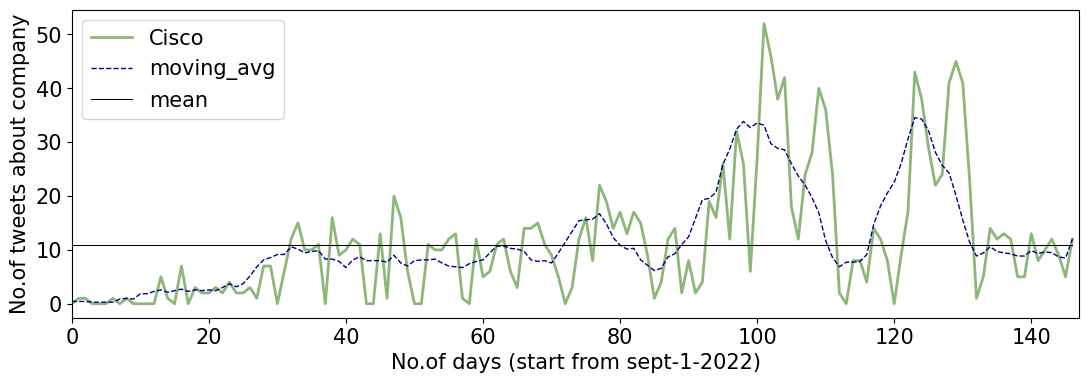

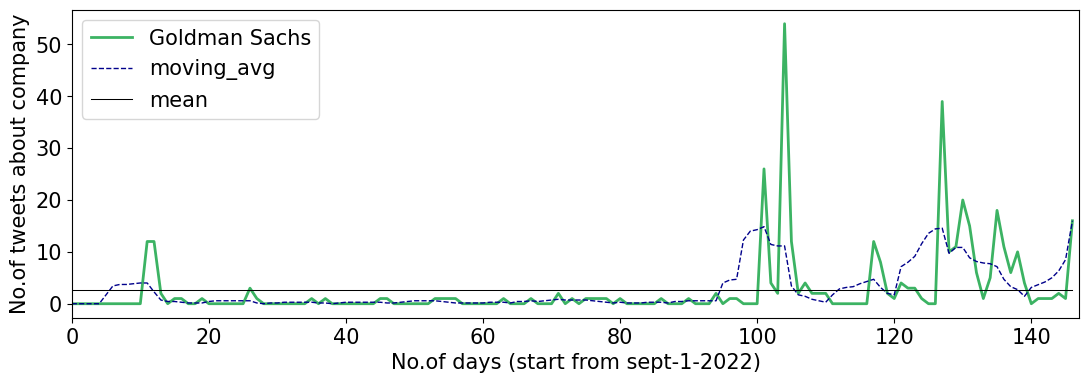

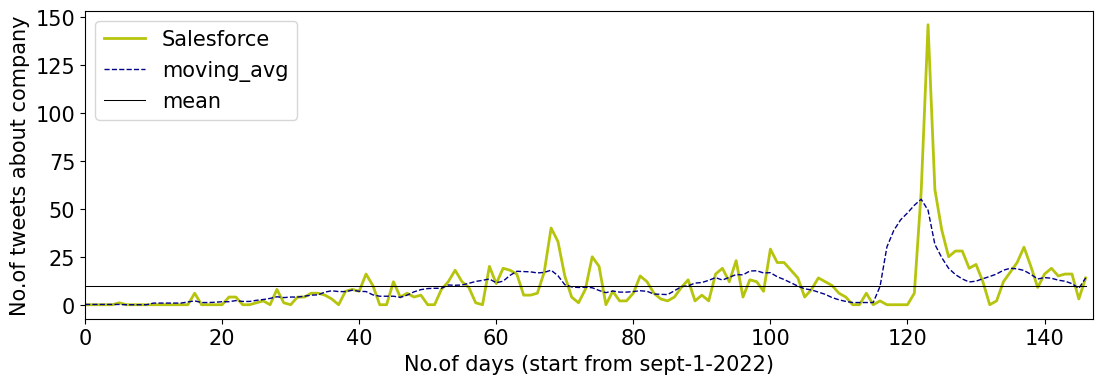

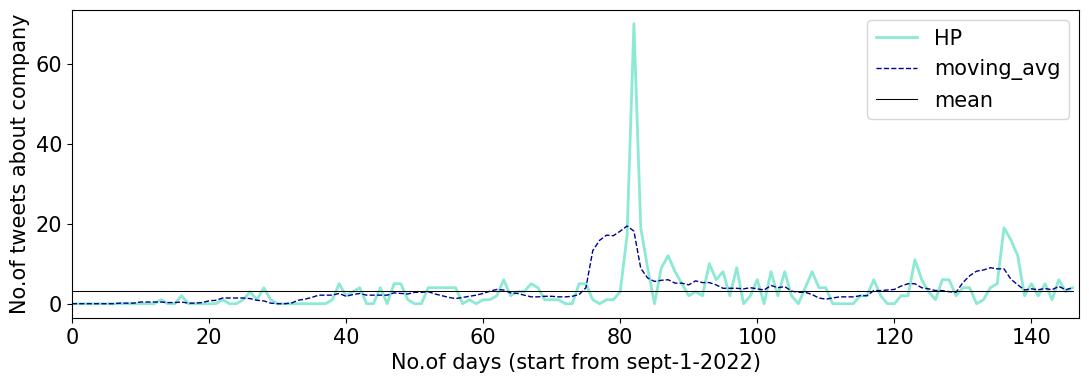

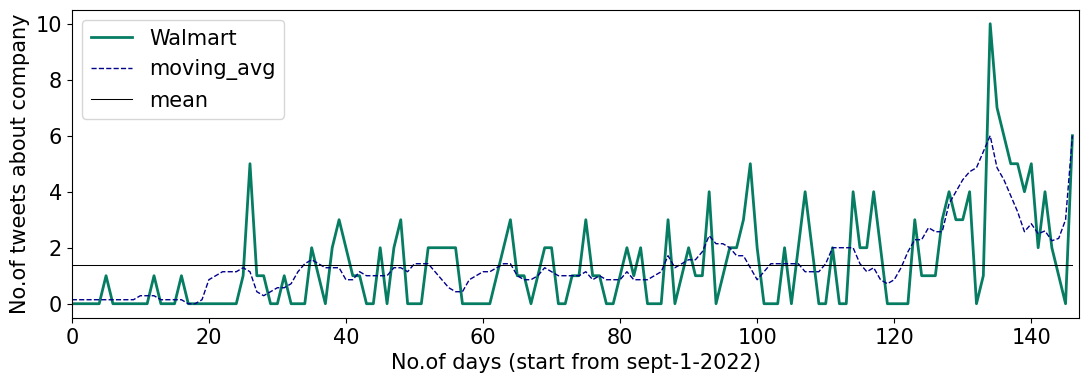

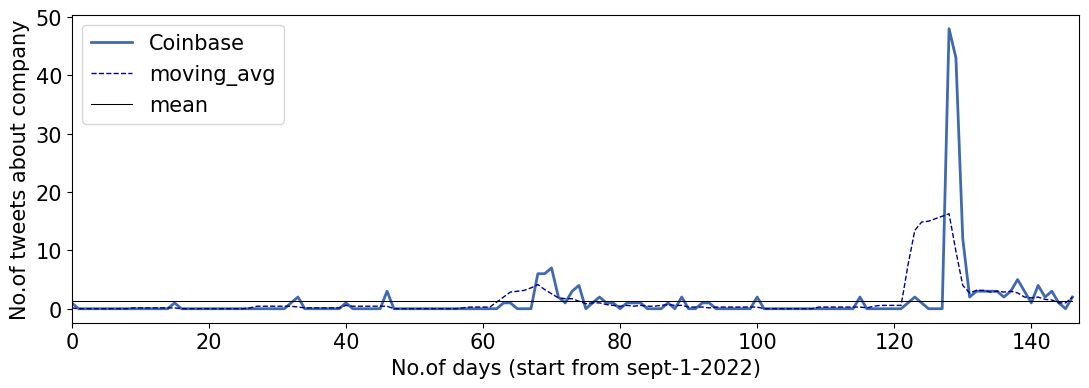

In [52]:
def gen_diff_colors(n):
    hexadecimal_alphabets = '0123456789ABCDEF'
    color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n)]
    return color


def get_induvidual_hist_comp(df1_copy_indfix, companies, color_arr):

    i = 0
    for k in comp_hist_dict.keys():
        
        mov_avg = moving_average(comp_hist_dict[k])
        
        plt.figure(figsize=(13, 4))
        plt.plot(comp_hist_dict[k], label= k, linewidth = 2, c = color_arr[i])
        plt.plot(mov_avg, label= "moving_avg", linestyle = "--",linewidth = 1, c = "darkblue")
        
        plt.plot([np.mean(mov_avg) - 0.05*np.mean(mov_avg)]*(len(mov_avg)), label= "mean", linewidth = 0.75, linestyle = "-", c = "black")


        
        plt.legend(loc='best')
        plt.xlim((0, len(comp_hist_dict[list(comp_hist_dict.keys())[0]])))
        plt.xlabel("No.of days (start from sept-1-2022)", fontsize = 15)
        plt.ylabel("No.of tweets about company", fontsize = 15)
        plt.show()
        i += 1
    
color_palletes = gen_diff_colors(len(companies))
get_induvidual_hist_comp(df1_copy_indfix, companies, color_palletes)

In [53]:
mov_avg_dict_comp = {}

for k in comp_hist_dict.keys():
    
    mov_avg = moving_average(comp_hist_dict[k])
    mov_avg_dict_comp[k] = mov_avg

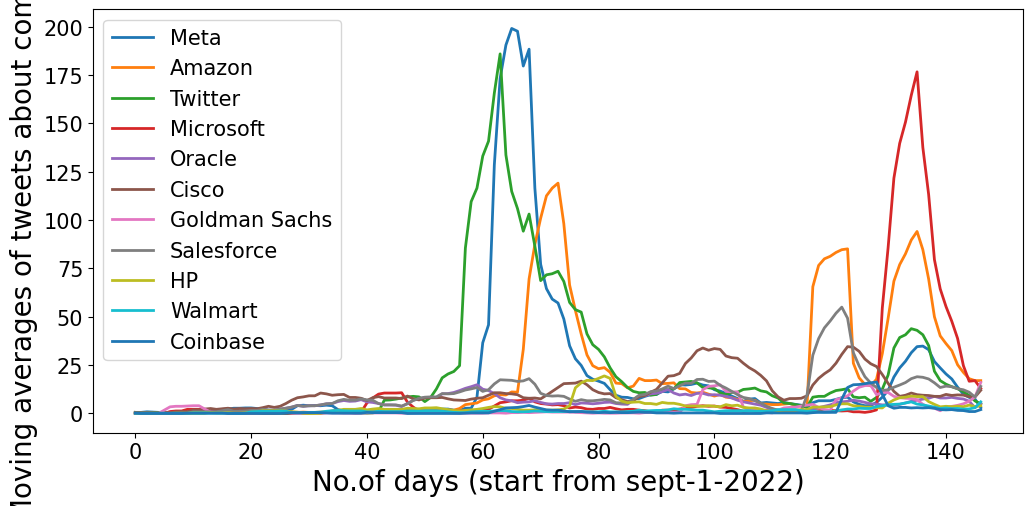

In [54]:
plt.figure(figsize=(12,5.5))

for k in mov_avg_dict_comp.keys():
    
    plt.plot(mov_avg_dict_comp[k], label= k, linewidth = 2)
    
    
plt.legend(loc='best')
plt.xlabel("No.of days (start from sept-1-2022)", fontsize = 20)
plt.ylabel("Moving averages of tweets about company", fontsize = 20)
plt.show()

**From all the above histograms ,we could see that the big-tech giant companies like Google, Twitter, Amazon, Meta,.. are represented by the huge peaks and the others have relatively less amplitude than these**

## **Getting the seasonal peaks and trends from the data**

In [55]:
def get_continuous_intervals(data, threshold):
    intervals = []
    start = None
    end = None
    for i, value in enumerate(data):
        if value >= threshold:
            if start is None:
                start = i
            end = i
        elif end is not None:
            intervals.append((start, end))
            start = None
            end = None
    if end is not None:
        intervals.append((start, end))
    return intervals


def get_peaked_timeind(company, mov_avg_arr):
    
    th = np.mean(mov_avg_arr) - 0.05*np.mean(mov_avg_arr)
    intervals = get_continuous_intervals(mov_avg_arr, th)
    
    return intervals

def filter_intervals(intervals, days_th):
    
    diff_arr = []
    for interval in intervals:
        diff = interval[1] - interval[0]
        diff_arr.append(diff)
    

    op_arr = []
    for i in range(len(diff_arr)):
        if diff_arr[i] >= days_th:
            op_arr.append(intervals[i])
            
    return op_arr

In [56]:
companies

['Meta',
 'Amazon',
 'Twitter',
 'Microsoft',
 'Oracle',
 'Cisco',
 'Goldman Sachs',
 'Salesforce',
 'HP',
 'Walmart',
 'Coinbase']

In [57]:
comp = companies[2]

comp_intervals = get_peaked_timeind(comp, mov_avg_dict_comp[comp])

days_th = 4
comp_intervals = filter_intervals(comp_intervals, days_th)
    
def plot_intervals(intervals, data, threshold, figsize=(15, 8), title=None):
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.axhline(y=threshold, color='r', linestyle='--', label = "threshold ="+str(threshold))
    for interval in intervals:
        plt.axvspan(interval[0], interval[1], color='g', alpha=0.5)
    if title:
        plt.title(title)
    plt.xlabel("index")
    plt.ylabel("No.of posts")
    plt.legend()
    plt.show()
    
    
# th = np.mean(mov_avg_dict_comp[comp]) - 0.10*np.mean(mov_avg_dict_comp[comp])
# title = "No.of posts about " + comp
# plot_intervals(comp_intervals, mov_avg_dict_comp[comp], th, figsize=(12,3), title = title)


In [58]:
def plot_waves(company, figsize=(10, 5)):
    
    comp = company

    comp_intervals = get_peaked_timeind(comp, mov_avg_dict_comp[comp])

    days_th = 4
    comp_intervals = filter_intervals(comp_intervals, days_th)

    def plot_intervals(intervals, data, threshold, figsize=(15, 8), title=None):
        plt.figure(figsize=figsize)
        plt.plot(data)
        plt.axhline(y=threshold, color='r', linestyle='--', label = "threshold ={:.2f}".format(threshold))
        for interval in intervals:
            plt.axvspan(interval[0], interval[1], color='g', alpha=0.5)
        if title:
            plt.title(title)
        plt.xlabel("index")
        plt.ylabel("No.of posts")
        plt.legend()
        plt.show()


    th = np.mean(mov_avg_dict_comp[comp]) - 0.10*np.mean(mov_avg_dict_comp[comp])
    title = "No.of posts about " + comp
    plot_intervals(comp_intervals, mov_avg_dict_comp[comp], th, figsize=figsize, title = title)


In [59]:
temp_df = pd.DataFrame(df1_copy_indfix['Date'].dt.date)
temp_df.index = [i for i in range(len(temp_df))]
    
q = '''
        SELECT DISTINCT(Date) AS date FROM temp_df
    '''
all_dates_df = duckdb.query(q).to_df()

all_dates_list = list(all_dates_df["date"])
print(len(all_dates_list))

147


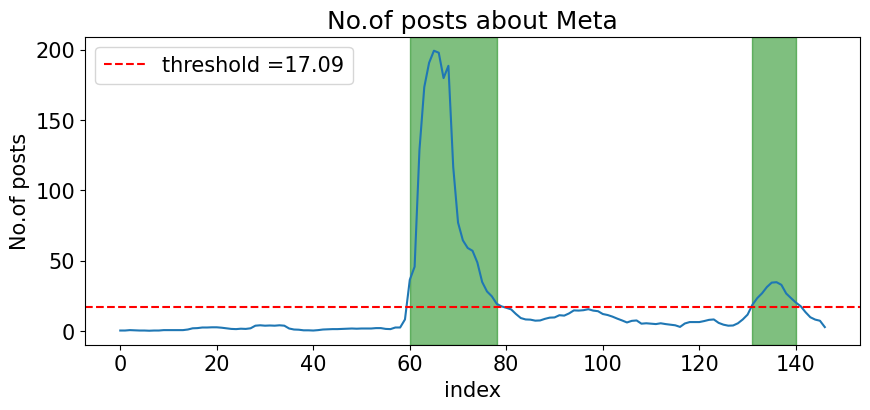

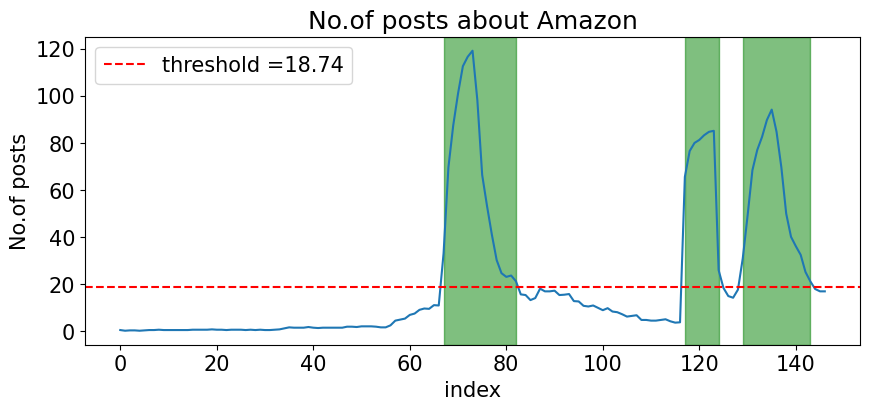

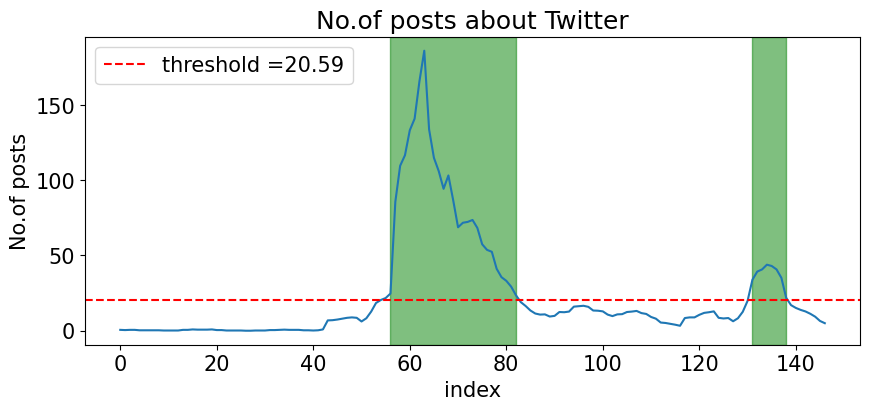

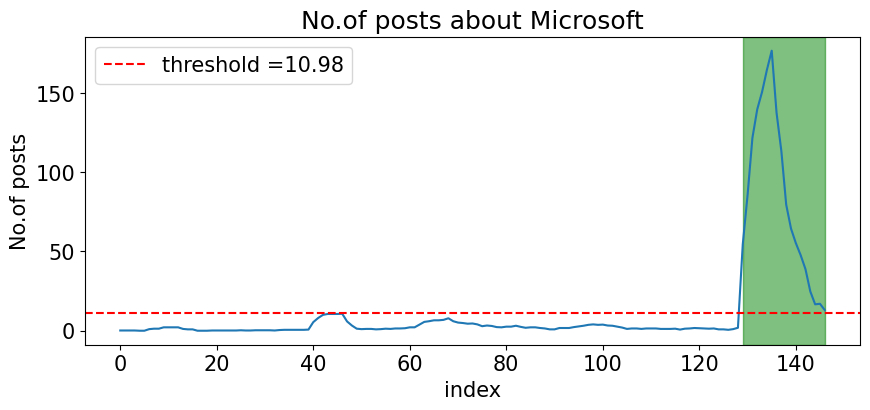

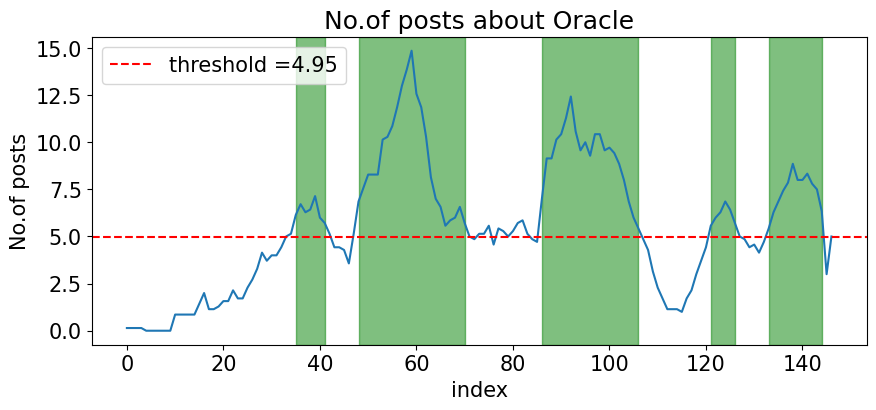

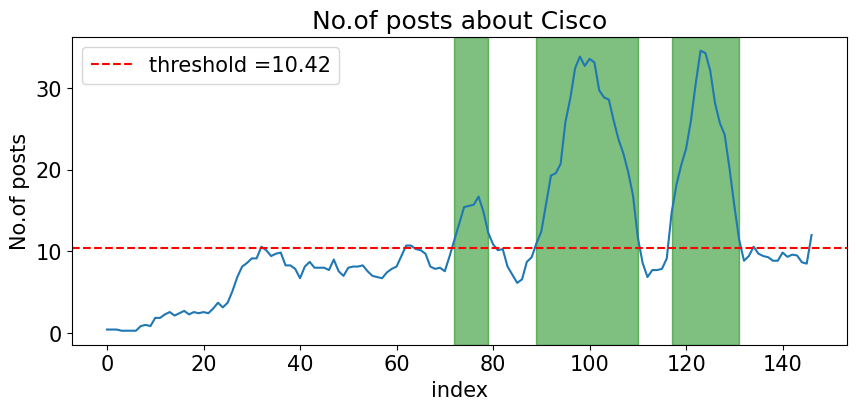

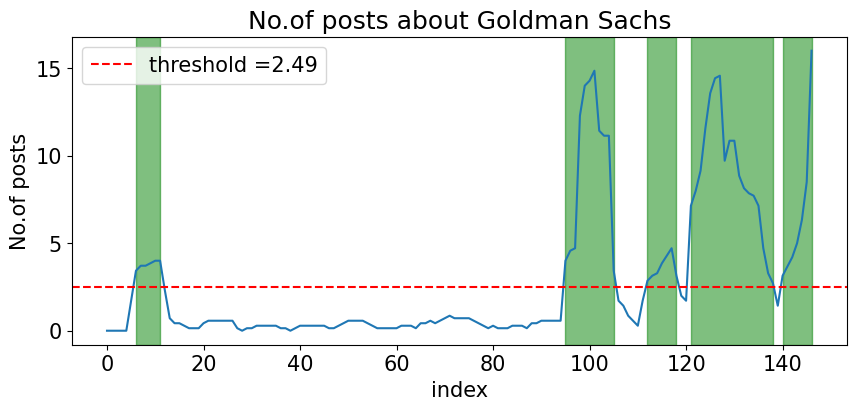

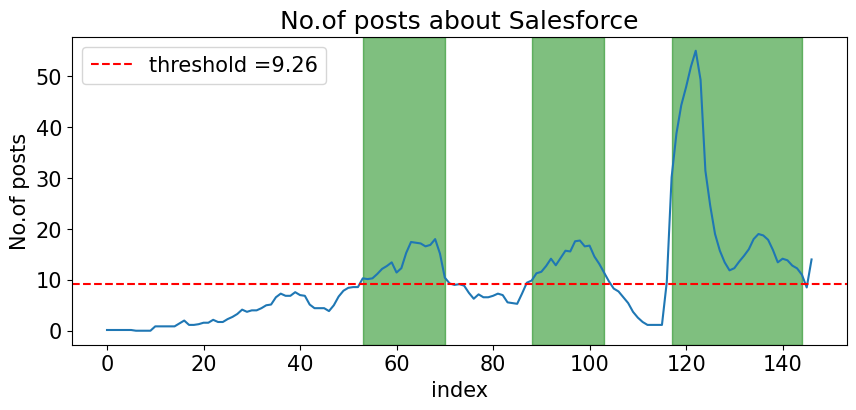

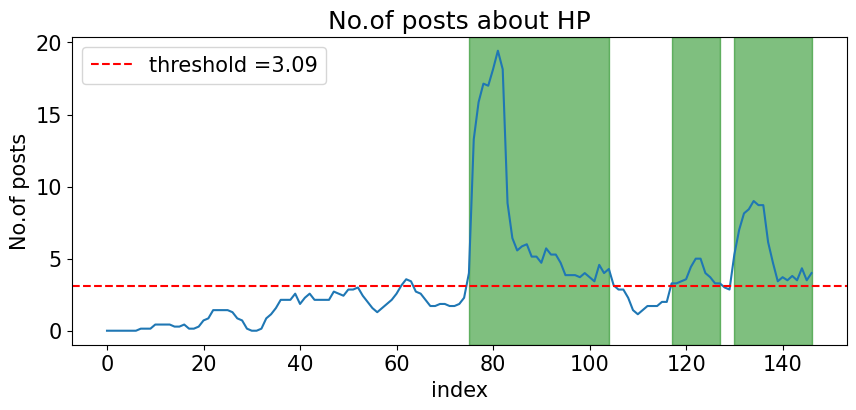

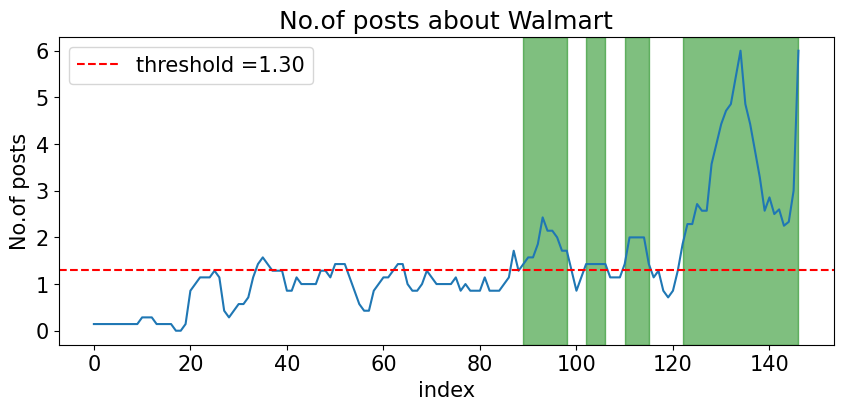

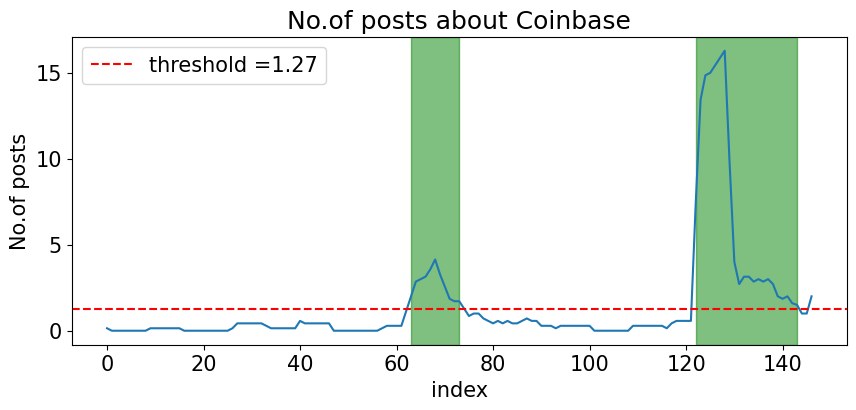

In [60]:
for c in companies:
    plot_waves(c, figsize=(10,4))

In [61]:
def get_num_tweets_hist_comp(df, compname, interval, dates_arr):
    
    req_df = df[(df["Date"] > dates_arr[interval[0]]) & (df["Date"] < dates_arr[interval[1]]) & (df[compname] == 1)]
    
    return req_df

def get_word_clouds_comp_chrono(company, mov_avg_dict, df , dates_arr, th = 4, figsize = (10,8)):
    
    comp_intervals = get_peaked_timeind(company, mov_avg_dict_comp[comp])
    days_th = th
    comp_intervals = filter_intervals(comp_intervals, days_th)
    
    i = 0
    for interval in comp_intervals:
        temp_df =  get_num_tweets_hist_comp(df, company, interval, dates_arr)
        
        curr_tweets = ""
        
        for t in temp_df["Tweet"]:
            curr_tweets += t
        
        
        print("Interval ", i, "->", dates_arr[interval[0]] , "to", dates_arr[interval[1]])
        stopwords = set(STOPWORDS)
        wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(curr_tweets)
        plt.figure( figsize=(10,8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        i += 1


In [62]:
df1_copy1 = df1_copy_indfix.copy()

df1_copy1['Tweet'] = df1_copy1['Tweet'].apply(lambda z: clean_text_complete(z))

Interval  0 -> 2022-10-28 00:00:00 to 2022-11-23 00:00:00


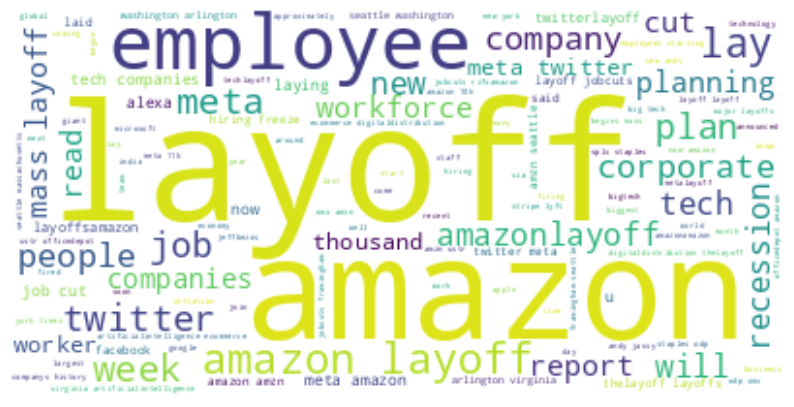

Interval  1 -> 2023-01-13 00:00:00 to 2023-01-21 00:00:00


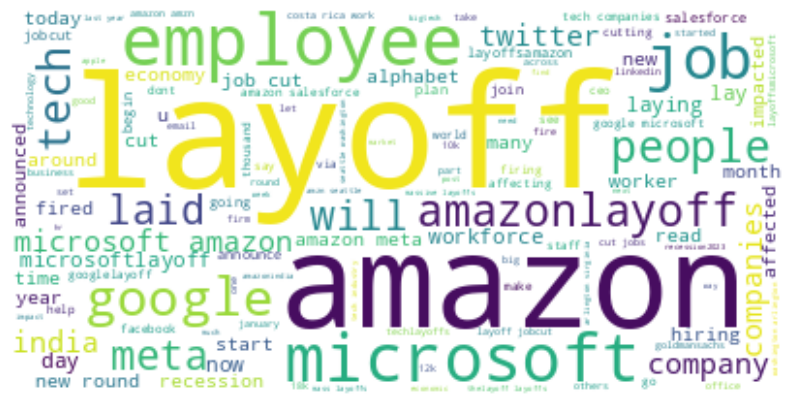

In [63]:
get_word_clouds_comp_chrono("Amazon", mov_avg_dict_comp, df1_copy1 , all_dates_list, th = 4)

In [64]:
NER = spacy.load("en_core_web_sm")


def get_ner_comp_chrono(company, mov_avg_dict, df , dates_arr, th = 4):
    
    comp_intervals = get_peaked_timeind(company, mov_avg_dict_comp[comp])
    days_th = th
    comp_intervals = filter_intervals(comp_intervals, days_th)
    
    i = 0
    for interval in comp_intervals:
        temp_df =  get_num_tweets_hist_comp(df, company, interval, dates_arr)
        
        print(temp_df["Tweet"])
        
        

# raw_text="The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."
# text1= NER(raw_text)
# for word in text1.ents:
#     print(word.text,word.label_)
# displacy.render(text1,style="ent",jupyter=True)

In [65]:
get_ner_comp_chrono("Meta", mov_avg_dict_comp, df1_copy , all_dates_list)

Date
2022-10-28 06:50:14    Facebook: Visitors are discussing potential an...
2022-10-28 14:58:28    According to a new report, @Meta managers are ...
2022-10-29 23:00:33    Hiring is a huge issue, and tech firms like @M...
2022-10-31 09:47:09    https://t.co/LinqDeRGPb\nFacebook\nMeta resear...
2022-10-31 09:47:09    https://t.co/LinqDeRGPb\nFacebook\nMeta resear...
                                             ...                        
2022-11-22 16:56:00    Laid-Off Meta Workers On US Visas Say The Comp...
2022-11-22 17:12:35    RT Talent_metrics "Laid-Off Meta Workers On US...
2022-11-22 19:57:20    "#TikTok Will #Hire Nearly 1,000 Silicon Valle...
2022-11-22 21:05:39    Twitter, Meta, Amazon and now Google - all lay...
2022-11-22 22:38:11    Companies like @Twitter, @Meta and @Lyft are a...
Name: Tweet, Length: 1894, dtype: object
Date
2023-01-13 05:34:20    JUST IN: Crypto exchange company @cryptocom ha...
2023-01-13 17:26:41    Meta Layoffs\n126 Employees\nSF Bay Area\n\nht...


# Analysing LinkedIn posts

In [66]:
df2 = pd.read_csv("linkedin_merged.csv")
print(df2.shape)

(40371, 7)


In [67]:
def convert_atr(data):
    conv_data = re.sub(r"@", " at ", data)
    return conv_data

def convert_and(data):
    conv_data = re.sub(r"&", " and ", data)
    return conv_data

def convert_comma(data):
    conv_data = re.sub(r"|", ", ", data)
    return conv_data

In [68]:
temp_jobs = df2.copy()
temp_jobs.shape

(40371, 7)

In [69]:
temp_jobs["job"] = temp_jobs["job"].apply(lambda z: remove_hashsymbol(z))
temp_jobs["job"] = temp_jobs["job"].apply(lambda z: convert_atr(z))
temp_jobs["job"] = temp_jobs["job"].apply(lambda z: convert_and(z))
temp_jobs["job"] = temp_jobs["job"].apply(lambda z: clean_text_complete(z))

In [70]:
del temp_jobs["Unnamed: 0"]
temp_jobs.reset_index(inplace = True)
del temp_jobs["index"]

# **Analysing the posts scrapped based on the job title and designation**

Analysis of the data on a whole based on the occupation of the person posting about layoffs.

In [71]:
def get_shortform(role):
    role_comps = role.split(" ")
    if len(role_comps) > 1:
        sf = ""
        for r in role_comps:
            sf += r[0]

        return sf
    
    else:
        return role
    
def get_sf_dict(arr):
    
    dict1 = {}
    
    for i in range(n):
        curr_name = arr[i]
        curr_sf = get_shortforms(curr_name)
        
        dict1[curr_sf] = curr_name
        
    return dict1

In [72]:
top_lvl = ["ceo","cmo" ,"cso ", "cco", "coo" , "cto", "cao" ,"chief executive officer", "chief marketing officer","chief sales officer" ,"chief coordinating officer", "chief administrative officer", "chief technology officer" ,"chief operating officer", "chief of staff","executive director", "president", "vice president", "managing director", "md", "chairman", "chairperson", "non executive director", "owner", "founder", "co founder", "cofounder" ,"co-founder" ,"non executive director", "executive vice presisdent", "executive president", "chief people officer", "executive director", "global head", "chief revenue officer", "cro", "founding member", "board of directors", "vice chancellor", "chancellor", "vp", "director of", "associate director"]
len(top_lvl)


43

In [73]:
mid_lvl = ["finance manager" ,"product manager", "project manager" , "research manager", "proposal manager", "business manager" , "administrative manager" , "development manager", "senior manager" ,"branch manager", "purchase manager", "staff manager", "operation manager", "head", "project lead", "project head", "team lead", "recruitment manager", "hr", "hr manager", "human resource manager", "project coordinator", "coordinator", "project head", "recruiter", "head of", "leader of", "supply chain manager", "social media manager", "associate principals", "ap", "principal associate", "pa", "management", "program manager", "programme manager", "account manager", "branch manager", "senior", "delivery lead", "marketing manager", "sr", "senior", "dean", "general manager", "avp", "assistant vice president", "account director", "associate engineer" , "ae", "digital marketing director"]
len(mid_lvl)


51

In [74]:
low_lvl = ["engineer", "instructor", "career coach", "career instructor", "trainer", "data scientist", "designer", "analyst", "author", "social media handler", "se", "sde", "swe", "advisor", "business development executive", "bde", "sme", "scientist", "strategist", "specialist", "proposal writer", "banker", "mle", "connector", "researcher", "intern", "content creator", "creator", "software developement engineer", "rpo", "recruitment process outsourcing", "social worker", "operator", "consultant", "developer", "ux enginnering", "engineering", "stundent", "writer", "author", "freelance", "freelancer", "blogger", "inspector", "supervisor", "junior manager", "devop", "customer experience professional", "open to work", "entrepreneur", "adjuster", "editor", "journalist", "mentor", "coach",  "teacher", "developer", "economist", "scholar", "research scholar", "professor", "lecturer", "interviewer", "consultant", "reporter", "free lance", "free lancer", "programmer", "coder", "hacker", "doctor", "influencer", "photographer", "engineering", "problem solver", "storyteller", "marketing executive", "hr", "accountant", "blogger", "account manager", "followers", "customer account manager", "representative", "advisor", "architect", "research", "analysis", "assistant", "marketing specialist", "hr specialist", "learning", "open to", "actively looking", "mba", "bba", "btech", "bsc", "msc", "mtech", "technical sourcer", "system enigneer", "assistant engineer", "investor", "investment analyst", "realtor", "recruiting leader", "recruitment manager", "analytics leader", "data leader", "data engineer", "data analyst","resources manager", "commercial manager", "portfolio manager", "speaker", "finance executive", "quality assurance director", "actively hiring", "hiring", "fresher", "animator", "shareholder", "broker", "sales professional", "enthusiast"]
len(low_lvl)


126

In [75]:
all_lvls = top_lvl.copy()

all_lvls += mid_lvl
all_lvls += low_lvl

## Distributuon of posts based on the management levels in the top level of a company


In [76]:
levels = ['Top-Level Management', 'Middle-Level Management', 'Lower-Level Management']

top_level = ['ceo', 'chief executive officer', 'executive director', 'president', 'chairman', 'chairperson', 'owner', 'founder', 'co-founder', 'non-executive director', 'executive vice president', 'executive president']
middle_level = ['cmo', 'chief marketing officer', 'vice president', 'managing director', 'md', 'executive director', 'global head', 'chief people officer', 'executive director', 'chief revenue officer', 'cro', 'founding member', 'board of directors']
lower_level = ['cso', 'cco', 'cao', 'cto', 'coo', 'chief sales officer', 'chief coordinating officer', 'chief administrative officer', 'chief technology officer', 'chief operating officer', 'chief of staff', 'non-executive director', 'vp', 'director of', 'associate director', 'vice chancellor', 'chancellor']

def categorize_management(position):
    if position in top_level:
        return levels[0]
    elif position in middle_level:
        return levels[1]
    elif position in lower_level:
        return levels[2]
    else:
        return 'Level not found'
  

top_seg_dict = {}
for p in levels:
    top_seg_dict[p] = []
    
for p in top_lvl:
    curr_seg = categorize_management(p)
    if curr_seg != 'Level not found':
        top_seg_dict[curr_seg].append(p)

In [77]:
def match_word(text, word):
    pattern = re.compile(r'\b' + word + r'\b')
    match = re.search(pattern, text)
    if match:
        return True
    else:
        return False
    
def get_num_posts(df, job_title):
    c = 0
    sf = get_shortform(job_title)
    for i in range(len(df)):
        if match_word(df.iloc[i]["job"], job_title) or match_word(df.iloc[i]["job"], sf):
            c += 1
    return c

In [78]:
top_seg_dict_vals = {}

for k in top_seg_dict.keys():
    top_seg_dict_vals[k] = {}

for k in top_seg_dict.keys():
    
    for k1 in top_seg_dict[k]:
                
        top_seg_dict_vals[k][k1] = get_num_posts(temp_jobs, k1)

In [79]:
top_seg_dict_vals.keys()

dict_keys(['Top-Level Management', 'Middle-Level Management', 'Lower-Level Management'])

In [80]:
def get_tot_count1(dic):
    c = 0
    for k in dic.keys():
        c += dic[k]
        
    return c

In [81]:
top_lvl_c = get_tot_count1(top_seg_dict_vals["Top-Level Management"])

mid_lvl_c = get_tot_count1(top_seg_dict_vals["Middle-Level Management"])

low_lvl_c = get_tot_count1(top_seg_dict_vals["Lower-Level Management"])

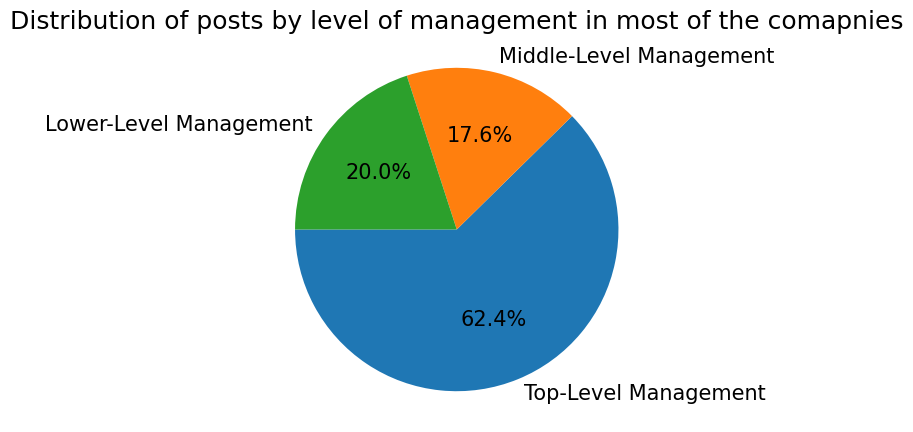

In [82]:
data = [top_lvl_c, mid_lvl_c, low_lvl_c]

# Labels for the pie chart
labels = list(top_seg_dict_vals.keys())

# Plot the pie chart
plt.figure(figsize = (5,5))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=180, radius=1.05)
plt.title('Distribution of posts by level of management in most of the comapnies')
plt.show()


In [83]:
all_roles = []
all_counts = []

for k in top_seg_dict.keys():
    
    for k1 in top_seg_dict[k]:
        all_roles.append(k1)
        all_counts.append(top_seg_dict_vals[k][k1])


In [84]:
data = all_counts
labels = all_roles

In [85]:
data_org = []
for i in range(len(data)):
    data_org.append([data[i],labels[i]])
    
data_org.sort(key=lambda x: x[0], reverse = True)

In [86]:
y_vals = []
x_vals = []
for i in range(len(data_org)):
    y_vals.append(data_org[i][0])
    x_vals.append(data_org[i][1])

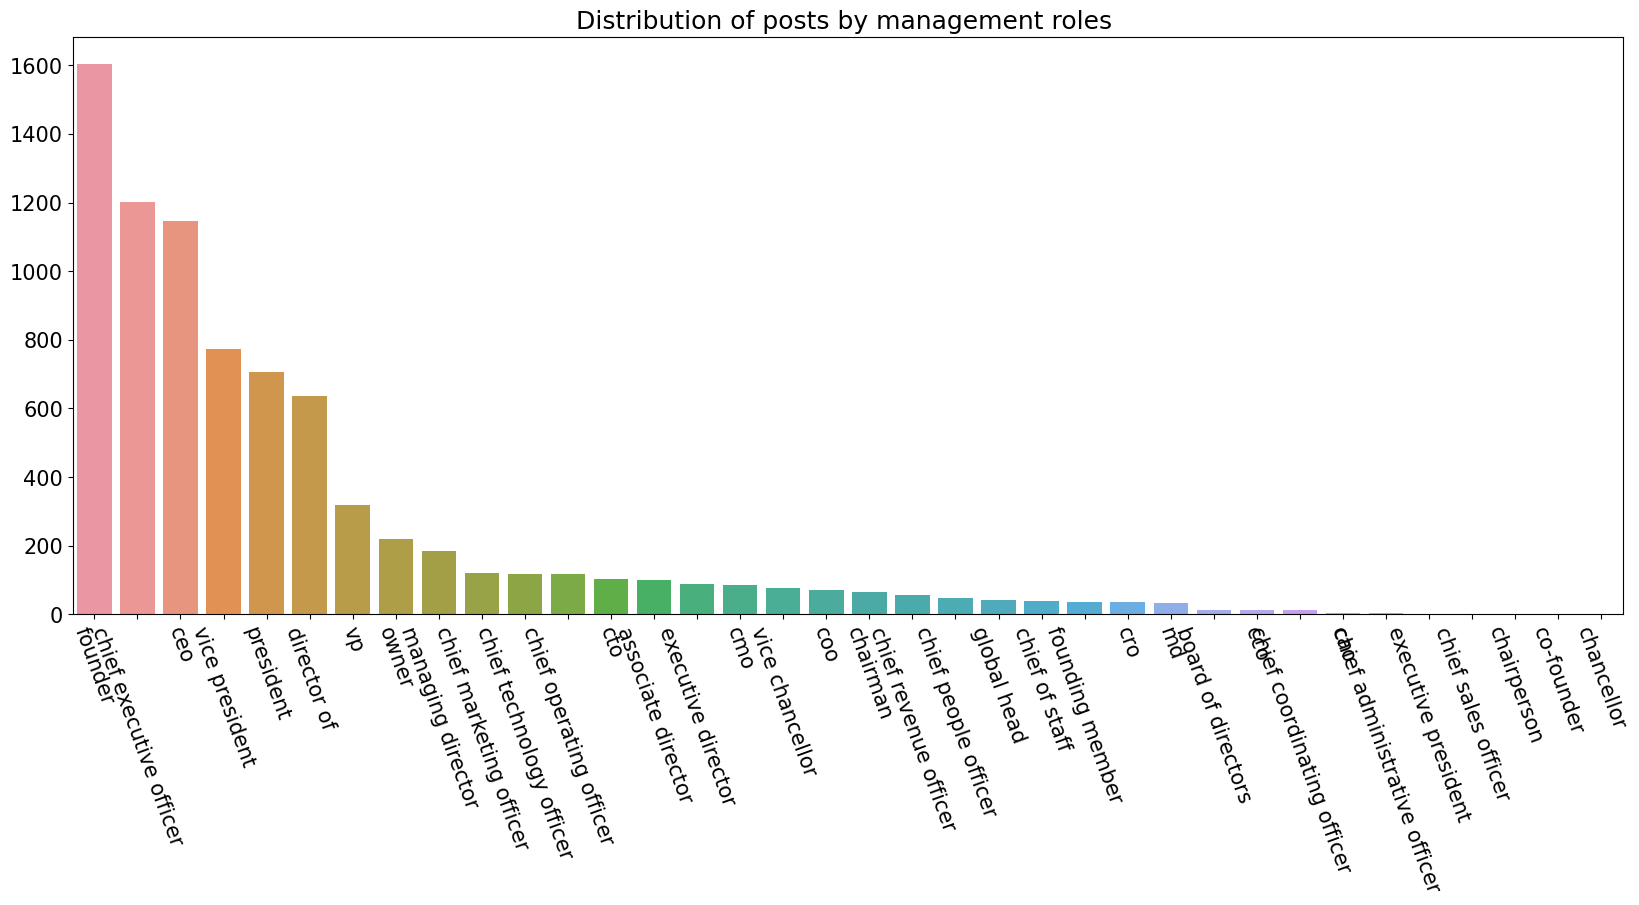

In [87]:
plt.figure(figsize = (20,7.5))
# plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=180, radius=1.5)
sns.barplot(x=x_vals, y=y_vals)
plt.title('Distribution of posts by management roles ')
plt.xticks(rotation=290)
plt.show()


In [88]:
temps = '''Technical:Engineer, Data Scientist, Designer, Analyst, Software Development Engineer, Developer, UX Engineer, Student, Programmer, Coder, Hacker, System Engineer, Assistant Engineer, Technical Sourcer, SE, SDE, SWE, UX engineer, engineering, assistant engineer, system engineer'''

temp1 = '''Academic: Instructor, Career Coach, Career Instructor, Trainer, Scientist, Researcher, Intern, Scholar, Research Scholar, Professor, Lecturer, Economist, BTech, BSc, MSc, MTech, Teacher, Influencer'''

temp2 = '''Creative:Author, Social Media Handler, Content Creator, Creator, Writer, Freelance, Freelancer, Blogger, Photographer, Storyteller, Animator'''

temp3 = '''Business:Business Development Executive, SME, Strategist, Specialist, Proposal Writer, Banker, Connector, Advisor, Marketing Executive, Accountant, Account Manager, Customer Account Manager, Representative, Architect, Marketing Specialist, HR Specialist, MBA, BBA, Sales Professional'''

temp4 = '''Finance:Investor, Investment Analyst, Realtor, Finance Executive, Shareholder, Broker'''

temp5 = '''Media:Journalist, Interviewer, Reporter, Editor, Photographer'''

temp6 = '''Leadership:CEO, CMO, CSO, CCO, COO, CTO, CAO, Chief of Staff, Executive Director, President, Vice President, Managing Director, MD, Chairman, Chairperson, Non-Executive Director, Executive Vice President, Executive President, Chief People Officer, Global Head, Chief Revenue Officer, Founding Member, Board of Directors, Vice Chancellor, Chancellor, Director of, Associate Director'''

temp7 = '''Human Resources:HR, Assistant, Learning, Resources Manager'''

temp8 = ''''''

In [89]:
df2_cleaned_txt = df2.copy()
df2_cleaned_txt["text"] = df2_cleaned_txt["text"].apply(remove_hashtags)

In [90]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [91]:
def clean_text_linkedin(text):
    text = clean(text, no_urls = True ,no_emoji=True, no_emails = True, lower = True, no_punct = True, no_currency_symbols=True, no_phone_numbers=True, replace_with_url="", replace_with_currency_symbol="", replace_with_email="", replace_with_phone_number="")
    return text

df2_cleaned_txt["text"] = df2_cleaned_txt["text"].apply(clean_text_linkedin)

In [92]:
df2_cleaned_txt = remove_stopwords(df2_cleaned_txt, "text")

In [93]:
from langdetect import detect

def remove_non_english_words(texts):
    english_texts = []
    i = 0
    for text in texts:
        try:
            language = detect(text)
            if language == 'en':
                english_texts.append(text)
                eng_indices.append(i)
                
        except:
            pass
        i += 1
    return english_texts

texts = list(df2_cleaned_txt["text"])
english_texts = remove_non_english_words(texts)
print(len(english_texts))

38048


In [94]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess


# text_data = df2_cleaned_txt_eng["text"].values.tolist()
text_data = english_texts

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(text_data))

In [95]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [96]:
from pprint import pprint

# number of topics
num_topics = 25

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,decay=0.85,iterations=100, random_state = 666
                                      )
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(1,
  '0.016*"layoffs" + 0.007*"new" + 0.006*"time" + 0.005*"year" + '
  '0.005*"people" + 0.005*"help" + 0.005*"hiring" + 0.005*"many" + 0.004*"job" '
  '+ 0.004*"also"'),
 (11,
  '0.008*"layoffs" + 0.006*"companies" + 0.005*"company" + 0.005*"years" + '
  '0.005*"job" + 0.005*"year" + 0.004*"new" + 0.004*"time" + 0.004*"many" + '
  '0.004*"layoff"'),
 (2,
  '0.011*"experience" + 0.008*"work" + 0.008*"job" + 0.007*"help" + '
  '0.007*"years" + 0.006*"looking" + 0.006*"please" + 0.005*"layoffs" + '
  '0.005*"new" + 0.005*"share"'),
 (19,
  '0.016*"layoffs" + 0.011*"people" + 0.007*"employees" + 0.007*"tech" + '
  '0.006*"company" + 0.006*"hiring" + 0.005*"companies" + 0.005*"get" + '
  '0.005*"new" + 0.005*"many"'),
 (14,
  '0.012*"employees" + 0.011*"layoffs" + 0.010*"job" + 0.007*"company" + '
  '0.005*"people" + 0.005*"one" + 0.005*"new" + 0.004*"time" + 0.004*"work" + '
  '0.004*"year"'),
 (12,
  '0.012*"layoffs" + 0.007*"employees" + 0.005*"know" + 0.005*"new" + '
  '0.005*"work"

In [104]:
# import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.013662 -0.010366       1        1  11.381048
18    -0.024683 -0.017430       2        1  10.166103
9     -0.038034 -0.000675       3        1   9.329357
24    -0.011890 -0.001987       4        1   7.281958
14    -0.019886  0.002809       5        1   7.051737
8     -0.013036 -0.005100       6        1   6.064654
0     -0.008987  0.026042       7        1   4.374303
11    -0.016631 -0.020916       8        1   4.290182
1     -0.009770  0.013707       9        1   3.389898
19    -0.019874 -0.000888      10        1   3.116005
21    -0.010041  0.017865      11        1   2.977353
13     0.006177  0.017616      12        1   2.863638
16    -0.012641 -0.020228      13        1   2.746671
10    -0.009822 -0.024794      14        1   2.745496
22     0.001256  0.048503      15        1   2.610720
6      0.031775  0.004262      16        1   2.603775
20     0.007503 -0.004187      17        1   2.427311
17     0.036092 -0.000790      18        1   2.361667
3     -0.011999  0.038275      19        1   2.357625
4      0.019980  0.022293      20        1   2.059613
7     -0.011784 -0.037999      21        1   1.884045
23     0.012031  0.018553      22        1   1.771153
12     0.011840 -0.010356      23        1   1.644586
2      0.083245 -0.008124      24        1   1.441910
5      0.022840 -0.046084      25        1   1.059196, topic_info=        Term          Freq         Total Category  logprob  loglift
173  layoffs  27469.000000  27469.000000  Default  30.0000  30.0000
416      job  14999.000000  14999.000000  Default  29.0000  29.0000
35    layoff   7011.000000   7011.000000  Default  28.0000  28.0000
28    hiring   7158.000000   7158.000000  Default  27.0000  27.0000
104   people  13335.000000  13335.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
34      know     67.730104   9241.114704  Topic25  -5.8498  -0.3682
544     work     66.270589   9637.316473  Topic25  -5.8716  -0.4320
105   please     57.263247   6505.703008  Topic25  -6.0177  -0.1851
38      like     58.995279   8227.641754  Topic25  -5.9879  -0.3901
416      job     60.526476  14999.458010  Topic25  -5.9623  -0.9650

[2142 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
20654      1  0.192227    aa
20654      2  0.024028    aa
20654      4  0.048057    aa
20654      6  0.072085    aa
20654      7  0.600711    aa
...      ...       ...   ...
15163     13  0.021907  zoho
15163     16  0.175255  zoho
15163     21  0.240976  zoho
15163     22  0.043814  zoho
9150      13  0.738177  zume

[9160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 19, 10, 25, 15, 9, 1, 12, 2, 20, 22, 14, 17, 11, 23, 7, 21, 18, 4, 5, 8, 24, 13, 3, 6])

In [103]:
pyLDAvis.

In [105]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [106]:
NER = spacy.load("en_core_web_sm")

In [107]:
raw_text="The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."
text1= NER(raw_text)
for word in text1.ents:
    print(word.text,word.label_)
displacy.render(text1,style="ent",jupyter=True)

The Indian Space Research Organisation ORG
India GPE
Bengaluru GPE
Department of Space ORG
India GPE
ISRO ORG
DOS ORG


/Users/sreevaatsav/.pyenv/versions/project_env/lib/python3.10/site-packages/spacy/displacy/__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [108]:
for word in text1.ents:
    print(word.text,word.label_)

The Indian Space Research Organisation ORG
India GPE
Bengaluru GPE
Department of Space ORG
India GPE
ISRO ORG
DOS ORG


In [ ]:
displacy.render(text1,style="ent",jupyter=True)

In [110]:
!pip3 freeze

altgraph @ file:///System/Volumes/Data/SWE/Apps/DT/BuildRoots/BuildRoot2/ActiveBuildRoot/Library/Caches/com.apple.xbs/Sources/python3/python3-124/altgraph-0.17.2-py2.py3-none-any.whl
anyio==3.6.2
appdirs==1.4.4
appnope==0.1.3
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.2.0
attrs==22.1.0
backcall==0.2.0
beautifulsoup4==4.11.1
bleach==5.0.1
blis==0.7.9
bs4==0.0.1
calplot==0.1.7.5
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
charset-normalizer==2.1.1
clean-text==0.6.0
click==8.1.3
confection==0.0.4
contourpy==1.0.7
cssselect==1.2.0
cycler==0.11.0
cymem==2.0.7
debugpy==1.6.4
decorator==5.1.1
defusedxml==0.7.1
emoji==1.7.0
entrypoints==0.4
executing==1.2.0
fake-useragent==1.1.0
fastjsonschema==2.16.2
filelock==3.9.0
Flask==2.2.2
fonttools==4.38.0
ftfy==6.1.1
future @ file:///System/Volumes/Data/SWE/Apps/DT/BuildRoots/BuildRoot2/ActiveBuildRoot/Library/Caches/com.apple.xbs/Sources/python3/python3-124/future-0.18.2-py3-none-any.whl
idna==3.4
importlib-metadata==5.1.0
imp